# Project Report - Data Science 
## Bachelor in Computer Science / PUCPR

Professor Jean Paul Barddal

`Gabriel Henrique Przytocki` gabrielhprzytocki@gmail.com

`Pedro Henrique Contessoto` pedro.contessoto@pucpr.edu.br

`Allan Braun` allanvobraun@gmail.com

`Valdemar Ceccon` valdemar.ceccon@gmail.com

`Matheus Bertho Tavares` matheus.berthot@gmail.com

2021
---

# Import the libs you need

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
from typing import List

import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,  \
                             RandomForestClassifier, \
                             BaggingClassifier

from sklearn.preprocessing import StandardScaler, \
                                  MinMaxScaler, \
                                  RobustScaler, \
                                  PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest

In [ ]:
plt.rcParams['figure.figsize'] = (10,5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading your data

<p align="justify"> Ao longo das seções do notebook, algumas variações dos dados originais foram criadas, segundo os propósitos de cada etapa. Por exemplo, na análise univariada foi utilizada uma ramificação dos dados transformados e sem valores faltantes, para tornar a análise mais fidedigna. Na etapa da análise Multivariada foram utilizadas três variações dos dados: uma versão transofrmada e sem valores faltantes, outra versão transformada com valores faltantes e por fim uma amostragem desta última. Esse processo foi utilizado para evidenciar relações nos dados independentemente do DataFrame escolhido. De maneira a tornar claro a nomenclatura dessas ramificações, segue a legenda abaixo: </p>

1. *DataFrames originais sem tratamento e remoção*
    - `df_train_raw`: DataFrame de **treino** original, sem tratamento e remoção
    - `df_test_raw`: DataFrame de **teste** original, sem tratamento e remoção

2. *DataFrames tratados e com remoção de valores faltantes*
    - `df`: DataFrame de **treino** tratado e com remoção de valores faltantes
    - `df_test`: DataFrame de **teste** tratado e com remoção de valores faltantes

3. *DataFrames tratados e sem remoção de valores*
    - `df_train_full`: DataFrame de **treino** tratado e sem a remoção de valores faltantes
    - `df_sample`: Amostragem obtida a partir do DataFrame de **treino** `df_full`

4. *DataFrames tratados e com remoção, destinados para ML*
    - `dfm`: DataFrame de treino destinado ao *Machine Learning*. Possui tratamento e valores faltantes
    - `dfm_test`: DataFrame de teste destinado ao *Machine Learning*.  Possui tratamento e valores faltantes


In [ ]:
path = 'drive/MyDrive/datasets/data-science-PUC-data/'
files = ['train.csv', 'test.csv']

df = pd.read_csv(os.path.join(path, files[0]), 
                 na_values=[-9999])

df_test = pd.read_csv(os.path.join(path, files[1]), 
                      na_values=[-9999])

df_train_raw = df.copy()
df_test_raw = df_test.copy()

In [ ]:
# Removendo dados sensíveis de maneira a assegurar a privacidade
# Lei 12.414

for d in [df, df_test]:
    d.drop(['ORIENTACAO_SEXUAL', 
            'RELIGIAO',
            'HS_CPF'], axis=1, inplace=True)

In [ ]:
# shape => (215178, 67)
df.head()

TEMPOCPF  DISTCENTROCIDADE  ...  ANOSULTIMADECLARACAOPAGAR  TARGET
0  20.338005         -0.120225  ...                        NaN     0.0
1  26.790774       2209.766591  ...                        NaN     0.0
2   9.596740         -0.097027  ...                        NaN     0.0
3  26.277938       3161.810493  ...                        NaN     0.0
4   4.565429               NaN  ...                        NaN     1.0

[5 rows x 67 columns]

In [ ]:
# shape => (92069, 66)
df_test.head()

TEMPOCPF  DISTCENTROCIDADE  ...  ANOSULTIMADECLARACAO  ANOSULTIMADECLARACAOPAGAR
0  12.744305       3346.643372  ...                   NaN                        NaN
1   9.647248       3177.763890  ...                   NaN                        NaN
2   7.053207        444.883898  ...              0.887971                   1.218105
3  10.062103       3024.452324  ...                   NaN                        NaN
4  26.051376       4039.864172  ...              0.767303                   0.413340

[5 rows x 66 columns]

## Limpeza dos Dados

Below, load the data using pandas and make all the necessary data cleansing so that all data types are correct for posterior analysis.

Conduzimos uma limpeza nos dados, de maneira a eliminar a sujeira.

In [ ]:
remove_negativos = lambda x: abs(x)

# Remoção de valores negativos
for dataframe in [df, df_test]:
    for col in dataframe.columns.values:
        if col.startswith('TEMPO') or \
           col.startswith('DIST') or \
           col.startswith('QTD') or \
           col.startswith('MEDIA') or \
           col.startswith('MENOR') or \
           col.startswith('MAIOR') or \
           col.startswith('PERCENT') or \
           col.startswith('IDH') or \
           col.startswith('ANOS') or \
           col.startswith('SEG') or \
           col.startswith('SOMA') or \
           col.startswith('INDICE') or \
           col.startswith('PORT'):
               dataframe[col] = dataframe[col].apply(remove_negativos)

In [ ]:
discretiza = lambda i: np.int32(float(i)) if str(i) != 'nan' else i

# Discretização de elementos
for dataframe in [df, df_test]:
    for col in dataframe.columns.values:
        if col.startswith('QTD') or \
           col.startswith('ANOS') or \
           'IDADE' in col and not 'MEDIA' in col:
                dataframe[col] = dataframe[col].apply(discretiza)

In [ ]:
df_train_full = df.copy()
df.dropna(inplace=True)

In [ ]:
# Novo shape => (4701, 67)
# Dados tratados
df.head()

TEMPOCPF  DISTCENTROCIDADE  ...  ANOSULTIMADECLARACAOPAGAR  TARGET
11   20.331897            4251.0  ...                        7.0     0.0
137  26.251748            3558.0  ...                        3.0     0.0
161  27.206652            9228.0  ...                        1.0     0.0
201  24.831440            9715.0  ...                       12.0     0.0
209  25.791640             606.0  ...                        1.0     0.0

[5 rows x 67 columns]

# Statistical Description of the Dataset

In [ ]:
df.describe()

TEMPOCPF  DISTCENTROCIDADE  ...  ANOSULTIMADECLARACAOPAGAR       TARGET
count  4701.000000       4701.000000  ...                4701.000000  4701.000000
mean     23.785968       3674.944480  ...                   3.880026     0.053180
std       4.044062       4531.896197  ...                   4.015458     0.224416
min       4.485312          0.000000  ...                   0.000000     0.000000
25%      21.919169        637.000000  ...                   1.000000     0.000000
50%      25.677517       2582.000000  ...                   2.000000     0.000000
75%      26.445101       4869.000000  ...                   6.000000     0.000000
max      28.412590      48998.000000  ...                  18.000000     1.000000

[8 rows x 67 columns]

In [ ]:
print(f'Total de Linhas: {len(df_train_raw)}')
print(f'Total de Linhas (faltantes removidos): {len(df)}')

Total de Linhas: 215178
Total de Linhas (faltantes removidos): 4701


In [ ]:
pd.options.display.max_rows = len(df_train_raw.columns)
round(df_train_raw.isna().sum() / len(df_train_raw), 2) \
                                  .sort_values(ascending=False)

ANOSULTIMADECLARACAOPAGAR       0.91
ANOSULTIMARESTITUICAO           0.84
ANOSULTIMADECLARACAO            0.65
SEGMENTACAOFINMEDIACASA         0.62
MEDIAIDADECASA                  0.62
SEGMENTACAOFINBAIXACASA         0.62
COBRANCAALTACASA                0.62
COBRANCAMEDIOCASA               0.62
COBRANCABAIXOCASA               0.62
INDICMENORDEIDADE               0.62
MAIORIDADECASA                  0.62
MENORIDADECASA                  0.62
FUNCIONARIOPUBLICOCASA          0.62
MEDIARENDACASA                  0.62
SOMARENDACASA                   0.62
MAIORRENDACASA                  0.62
MENORRENDACASA                  0.62
QTDPESSOASCASA                  0.62
SEGMENTACAOALTACASA             0.62
BOLSAFAMILIACASA                0.62
PERCENTFUNCIONARIOPUBLICOCEP    0.28
PERCENTPRIMARIOCEP              0.28
MEDIARENDACEP                   0.28
PERCENTBOLSAFAMILIACEP          0.28
PERCENTMASCCEP                  0.28
PERCENTFEMCEP                   0.28
PERCENTANALFABETOCEP            0.28
I

## Descrição das Variáveis para Análise Univariada

|                           |                                                                                                 |
|---------------------------|-------------------------------------------------------------------------------------------------|
| `TEMPOCPF`                | Tempo (em anos) desde a emissão do CPF                                                          |
| `DISTCENTROCIDADE`        | Distância (em metros) do CEP informado ao centro da cidade                                      |
| `INDICEEMPREGO`           | Índice de estabilidade do CPF no emprego                                                        |
| `IDHMUNICIPIO`            | IDH do município                                                                                |
| `MEDIARENDACEP`           | Renda presumida média das pessoas que vivem no mesmo CEP do proponente                          |
| `PERCENTSUPERIORCEP`      | Percentual de pessoas com escolaridade SUPERIOR INCOMPLETO que vivem no mesmo CEP do proponente |
| `MEDIARENDACASA`          | Renda Presumida média dos integrantes do Household                                              |
| `SOMARENDACASA`           | Soma das Rendas Presumidas de todos os integrantes do Household                                 |
| `PERCENTPOPZONAURBANA`    | Percentual da população do município vive na zona urbana                                        |
| `PERCENTMEDIOCEP`         | Percentual de pessoas com escolaridade MÉDIO INCOMPLETO que vivem no mesmo CEP do proponente    |
| `QTDCAMINHAOMUNICIPIO`    | Quantidade de veículos tipo caminhão por 1.000 habitantes no município                          |
| `ESTIMATIVARENDA`        | Estimativa de renda                                  |                         |                                                                 |
| `MEDIAIDADECASA`          | Idade média dos integrantes do Household                                                        |
| `PIBMUNICIPIO`            | PIB municipal per capito                                                                        |
| `PERCENTBOLSAFAMILIACEP`  | Percentual de pessoas inscritas no bolsa família que vivem no mesmo CEP do proponente           |
| `QTDPESSOASCASA`          | Quantidade de pessoas no household                                                              |
| `QTDDECLARACAOISENTA`          | Quantas vezes o CPF declarou imposto de renda como isento nos últimos 10 anos                                              |
| `QTDCELULAR`          | Quantos telefones celulares distintos o proponente possui na base                                                               |
| `BOLSAFAMILIACASA`        | Flag indicativo se algum integrante do Household participa do bolsa família                     |
| `FUNCIONARIOPUBLICO`      | Flag indicativo se o CPF é um funcionário público                                               |
| `TARGET`                  | Determinação se a proposta é inadimplente (1) ou não (0)                                        |

## *Insights* sobre as Variáveis Escolhidas

Abaixo, seguem alguns *insights* acerca das 7 variáveis escolhidas, dentre as 21 variáveis selecionadas para análise univariada (descritas acima). Os *insights* foram extraídos após a etapa univariada, como mencionado.

### Variável 1: `MEDIARENDACASA`

A variável da renda média da casa (`MEDIARENDACASA`) possui uma distribuição com uma grande assimetria positiva, da qual podemos observar uma grande frequência de rendas médias próximas de $\mu$, ou então até abaixo deste valor. Isso contrasta com os valores posteriores à $Q_3$, que tendem a ficar cada vez mais distantes de $\mu$. É notório, portanto, que as rendas médias são altamente desiguais, como podemos observar pela moda da base ser próxima de R\$ `2699`, bem como o valor menos frequente ser próximo a R\$ `30000`; fica mais evidente se considerarmos que 75% dos dados estão abaixo de aproximadamente R\$ `6900`, e que $\mu$ é próxima de R\$ `5628`, nesse caso constatamos que a maior parte dos dados são menores que a média, e que devido a poucas rendas médias muito superiores à $\mu$, tal valor não reflete quanto cada família da base de fato possui de renda. Também é o caso de $\sigma$, que é próximo de $\mu$, mas está associado à valores muito maiores que a média que acabam aumentando seu valor. Contudo, apesar de $\sigma$ ser próximo de $\mu$, a grande frequência de valores muito próximos da média exemplificam a discrepância dos valores, uma vez que a distribuição possui aspecto leptocúrtico ($k$ > 0). Por fim, a assimetria é positiva, uma vez que $v > 0$ e que $M_o < M_d < \mu$, exemplificando o que foi dito a respeito da discrepância entre a média, os quartis, o desvio padrão e os valores de fato mais frequentes da distribuição.

### Variável 2: `TEMPOCPF`

Esta variável possui dados bem próximos, com média ($\mu$) de aproximadamente `23`, desvio padrão ($\sigma$) de aproximadamente `4`, quartil 1 ($Q_1$) de aproximadamente `21`, quartil 2 ($Q_2$), ou mediana ($M_d$) de aproximadamente `25` e quartil 3 ($Q_3$) de aproximadamente `26`. Observa-se que o valor `4` causa uma assimetria negativa nos dados, gerando uma cauda para o lado esquerdo do eixo $x$. Em uma etapa de Machine Learning, é interessante normalizar essa distribuição, eliminando valores que geram tal cauda.

### Variável 3: `MEDIAIDADECASA`

Observa-se que os valores aparentemente são mais próximos uma vez que a média tende a ser igual a moda e a mediana. Contudo, também é possível observar uma discrepância de valores mínimos e máximos (respectivamente `12` e 90); contudo, um fato importante é que o quartil  $Q3$  equivale a `49`, representando uma longa distância até o valor máximo supracitado. Essa distribuição possui tal aspecto normal, e esse fato é esperado, uma vez que a média da idade é um fator altamente randômico, tendendo à distribuições gaussianas. Em uma etapa de Machine Learning, a depender do modelo e das técnicas utilizadas, essa característica normal da distribuição pode ser algo benéfico.

### Variável 4: `IDHMUNICIPIO`

Observa-se que a distribuição possui uma cauda para o lado negativo do eixo $x$, apesar de ter um aspecto levemente normal.

Alguns valores importantes: Média ($\mu$) é aproximadamente `75`; Desvio padrão ($\sigma$) é aproximadamente `5`; Quartil 1 ($Q_1$) é aproximadamente `73`; Quartil 2 ($Q_2$), ou mediana ($M_d$) é aproximadamente `75`; Quartil 3 ($Q_3$) é aproximadamente `85`. Com relação à distribuição, considerando ainda a assimetria e a curtose, observamos que: A distribuição **não é normal**, pois $M_o \ne \mu$ e $M_d \ne \mu$; A distribuição possui **assimetria negativa** ($v < 0$), portando cauda pro lado esquerdo do eixo $x$; Possui **cauda pro lado negativo** do eixo $x$; Possui curtose maior que zero ($k > 0$), indicando uma **distribuição leptocúrtica**; A moda é menor que a mediana, que por sua vez é menor que a média ($M_o < M_d < \mu$). Por fim, podemos notar que os valores dos respectivos quartis são bem próximos, bem como exemplificado pelo baixo valor de desvio-padrão ($\sigma$), se comparado à média ($\mu$).

### Variável 5: `QTDCAMINHAOMUNICIPIO`

Notamos uma grande discrepância entre o valor mínimo (`min`), equivalente a `0` e `max`, equivalente a `92`. Alguns valores importantes: Média ($\mu$) é aproximadamente `15`; Desvio padrão ($\sigma$) é aproximadamente `7`; Quartil 1 ($Q_1$) é aproximadamente `9`; Quartil 2 ($Q_2$), ou mediana ($M_d$) é aproximadamente `15`; Quartil 3 ($Q_3$) é aproximadamente `20`. Com relação à distribuição, considerando ainda a assimetria e a curtose, observamos que: A distribuição **não é normal**, pois $M_o \ne \mu$ e $M_d \ne \mu$; A distribuição possui **assimetria positiva** ($v > 0$), portando cauda pro lado direito do eixo $x$; Possui **cauda pro lado positivo** do eixo $x$; Possui curtose maior que zero ($k > 0$), indicando uma **distribuição leptocúrtica**; A moda é menor que a mediana, que por sua vez é menor que a média ($M_o < M_d < \mu$); O desvio padrão ($\sigma$) é próximo da média, porém a maior parte dos dados (até $Q_3$) são muito próximos da média, configurando uma distribuição leptocúrtica.

### Variável 6: `FUNCIONARIOPUBLICO`

Possui uma maioria de indivíduos não funcionários públicos, sendo `2809` não atuando em tais cargos, frente a `1892` que atuam nos cargos mencionados. Essa classe é desbalanceada, podendo afetar os modelos de Machine Learning.

### Variável 7: `TARGET`

Assim como na variável de funcionários públicos, o `TARGET` possui uma maioria de indivíduos adimplentes (`0`), frente a uma minoria inadimplente (`1`), respectivamente `4451` e `250`. Considerando que essa variável é o atributo chave da classificação, estamos diante de um problema de desbalanceamento de classes, fato esse que nos leva ao risco de "viviar" nosso modelo de Machine Learning em dados de uma classe somente (visto a maioria de amostras), no nosso caso a classe de adimplência (`0`). Existem algumas técnicas para mitigar essa problemática, tais como `SMOTE` e `NeverMiss`. Contudo, nenhum desses algoritmos assegura uma maior precisão ou ganho após sua utilização, como é o caso do modelo criado na seção de *Machine Learning* desse *notebook*.

# Univariate data analysis

In this section, you should perform univariate data analysis on at least 20 variables. 

In the end, you should describe the main variables that are of your interest, and these should be accounted for in the next sections of the report.
The definition of each variable chosen should be clarified, so arbitrary selections are **not** accepted at this point.

For each variable plotted, make sure you determine the following:
1. The distribution of the data (gaussian, binomial, exponential, etc)
2. Skew
3. Kurtosis
4. Mean, standard deviation, and what they stand for in the context of the dataset

Regardless of the type of the variable being analyzed, make sure you plot it correctly. For instance, make sure scatterplots are not used for categorical data and so forth.

## Distribuições

Abaixo, vamos realizar a plotagem das distribuições das variáveis numéricas contínuas. Para o caso das discretas, vamos utilizar um `countplot`, como é o caso das 6 últimas da lista.

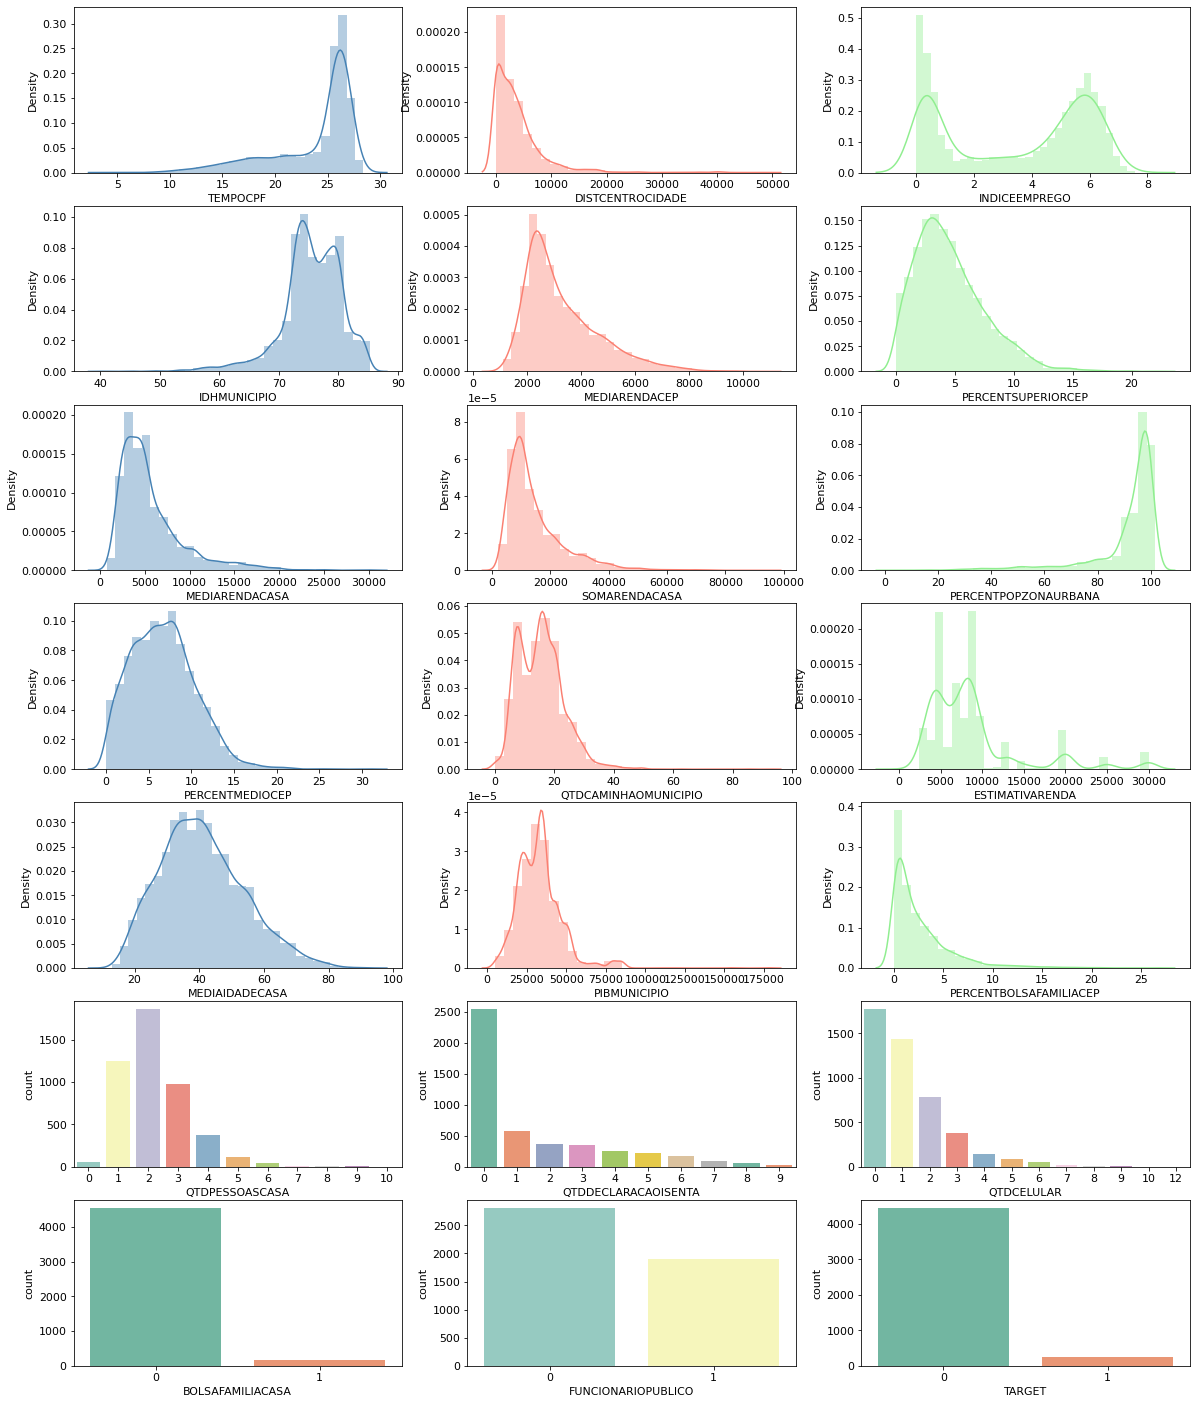

In [ ]:
# 21 variáveis selecionadas para análise univariada
interest_variables = ['TEMPOCPF', 'DISTCENTROCIDADE', 'INDICEEMPREGO',
                      'IDHMUNICIPIO', 'MEDIARENDACEP', 'PERCENTSUPERIORCEP', 
                      'MEDIARENDACASA', 'SOMARENDACASA', 'PERCENTPOPZONAURBANA', 
                      'PERCENTMEDIOCEP', 'QTDCAMINHAOMUNICIPIO', 'ESTIMATIVARENDA',
                      'MEDIAIDADECASA', 'PIBMUNICIPIO', 'PERCENTBOLSAFAMILIACEP',
                      'QTDPESSOASCASA', 'QTDDECLARACAOISENTA', 'QTDCELULAR',
                      'BOLSAFAMILIACASA', 'FUNCIONARIOPUBLICO', 'TARGET']

plt.rc('font', size=11)
fig, ax = plt.subplots(7, 3, figsize=(20,25))

colors = ['steelblue', 'salmon', 'lightgreen']
palettes = ['Set2', 'Set3']

for variable, i in zip(interest_variables, 
                       range(len(interest_variables))):
    
    if i >= len(interest_variables) - 6:
        df[variable] = df[variable].astype(np.int32)
        sns.countplot(df[variable], 
                      palette=palettes[i%len(palettes)],
                      ax=ax[i//3][i%3]);
        continue
    else:
        sns.distplot(df[variable], 
                     ax=ax[i//3][i%3], 
                     bins=30, 
                     color=colors[i%len(colors)]);

plt.show();

## Assimetria, Curtose, Média e Desvio-Padrão

Para cada uma das variáveis escolhidas, vamos calcular alguns valores, são eles:
- Assimetria (*Skew*)
- Curtose (*Kurtosis*)
- Média (*Mean*)
- Desvio-Padrão (*Std*)

In [ ]:
unv = pd.DataFrame()

for feature, i in zip(interest_variables, 
                      range(len(interest_variables))):
    
    df_temp = pd.DataFrame({'Variável': feature,
                            'Skew': df[feature].skew(),
                            'Kurtosis': df[feature].kurtosis(),
                            'Mean': df[feature].mean(),
                            'Std': df[feature].std()}, index=[i])
    
    unv = pd.concat((unv, df_temp), axis=0)

unv.set_index('Variável', inplace=True)

pd.options.display.max_rows = 40
unv

Skew   Kurtosis          Mean           Std
Variável                                                               
TEMPOCPF               -1.452094   1.225253     23.785968      4.044062
DISTCENTROCIDADE        3.403816  19.544403   3674.944480   4531.896197
INDICEEMPREGO          -0.224090  -1.649376      3.502665      2.496924
IDHMUNICIPIO           -1.160513   3.262237     75.528801      5.036516
MEDIARENDACEP           1.247243   1.557130   3273.553542   1365.211966
PERCENTSUPERIORCEP      1.004416   1.417454      4.583713      2.955018
MEDIARENDACASA          1.973258   5.125203   5628.816833   3654.992259
SOMARENDACASA           1.980055   5.546331  14687.531891   9865.607742
PERCENTPOPZONAURBANA   -2.743374   8.146442     91.361717     13.104602
PERCENTMEDIOCEP         0.570111   0.635428      6.690109      3.748944
QTDCAMINHAOMUNICIPIO    1.085101   4.570004     15.457988      7.637881
ESTIMATIVARENDA         2.036549   4.210739   8625.884925   5673.078353
MEDIAIDADECASA          0.479701  -0.047804     40.983390     12.978669
PIBMUNICIPIO            1.744066   9.016385  33100.596224  14107.458238
PERCENTBOLSAFAMILIACEP  2.530101   9.025096      2.692054      3.187674
QTDPESSOASCASA          1.473024   4.522957      2.232716      1.194082
QTDDECLARACAOISENTA     1.419967   1.077858      1.504573      2.159745
QTDCELULAR              1.779532   4.475958      1.239949      1.450263
BOLSAFAMILIACASA        5.123570  24.261293      0.034248      0.181885
FUNCIONARIOPUBLICO      0.397898  -1.842461      0.402468      0.490447
TARGET                  3.983754  13.876198      0.053180      0.224416

## Discussão das Variáveis Escolhidas

Nessa seção, serão discutidas as 7 variáveis selecionadas dentre as 21 descritas. Os insights dessa etapa geraram o resumo de cada uma dessas variáveis na seção "Statistical Description of the Dataset". Serão discutidos aspectos das respectivas distribuições, assimetria, curtose, entre outros.

In [ ]:
def continuous_variable_plot(variable):
    plt.rc('font', size=10)
    fig, ax = plt.subplots(3, 2, figsize=(20,15))

    for i in range(6):
        
        if i == 0:
            df[variable].hist(bins=60,
                                    grid=False,
                                    ax=ax[i//2][i%2]);

        elif i == 1:
            sns.distplot(df[variable], 
                kde=True, 
                hist=True,
                color="g", 
                ax=ax[i//2][i%2],
                bins=60);

        elif i == 2:
            sns.boxplot(df[variable], 
                        color="lightblue",
                        ax=ax[i//2][i%2]);

        elif i == 3:
            sns.violinplot(df[variable], 
                        color="salmon",
                        ax=ax[i//2][i%2]);

        elif i == 4:
            quartis_labels = ['25', '50', '75']

            variable_quartis = pd.qcut(df[variable], 
                                          q=3,
                                          labels=quartis_labels)

            sns.boxplot(y=variable_quartis, 
                        x=df[variable],
                        ax=ax[i//2][i%2]);
                
        else:
            sns.scatterplot(data=df,
                            x='TEMPOCPF' if variable != 'TEMPOCPF' \
                                         else 'IDHMUNICIPIO', 
                            y=variable,
                            hue='TARGET', 
                            ax=ax[i//2][i%2],
                            palette="Set2");

    plt.show();

### Variável 1: `MEDIARENDACASA`

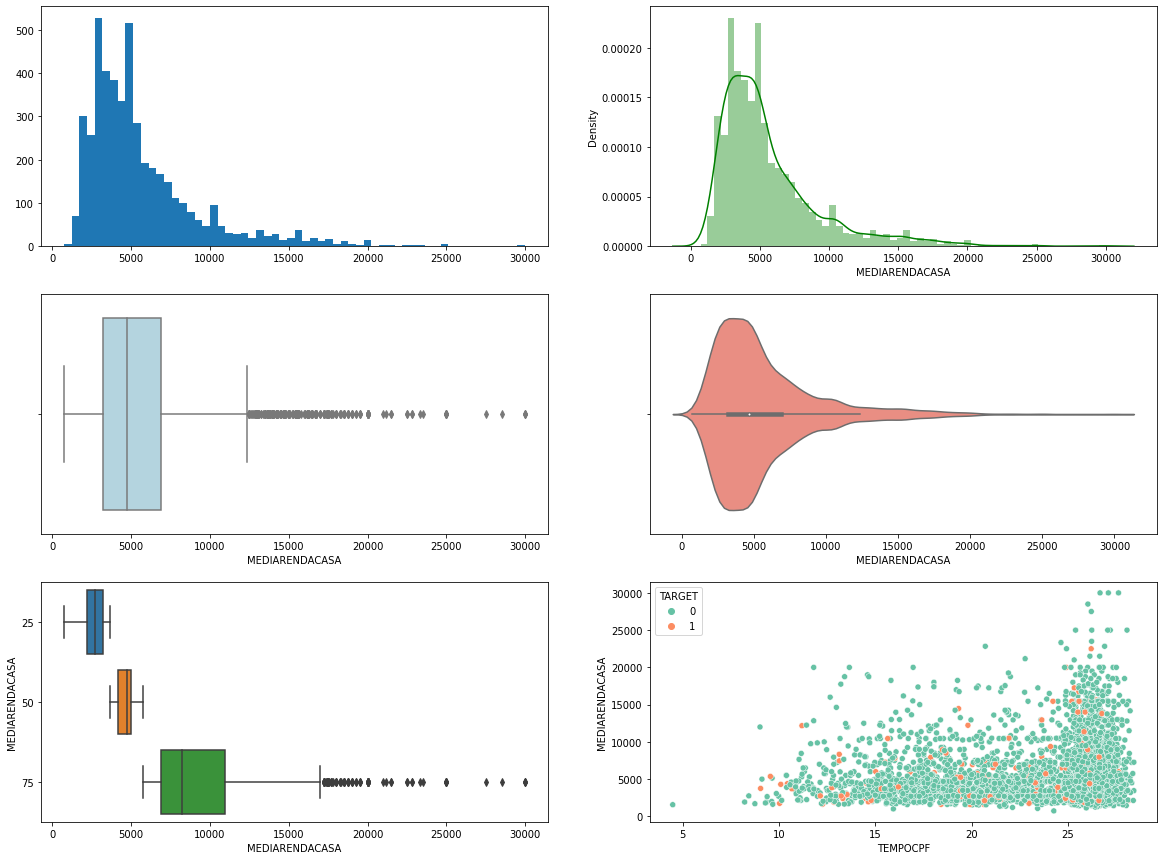

In [ ]:
continuous_variable_plot('MEDIARENDACASA')

In [ ]:
media_renda = df['MEDIARENDACASA'] \
              .map(lambda x: int(x) if str(x) != "nan" else np.nan)
              
int(media_renda.mode()[0])

2699

In [ ]:
# Assimetria e Curtose
print(f"Skew: {round(df['MEDIARENDACASA'].skew(),2)}")
print(f"Kurtosis: {round(df['MEDIARENDACASA'].kurt(), 2)}")

Skew: 1.97
Kurtosis: 5.13


In [ ]:
df['MEDIARENDACASA'].describe()

count     4701.000000
mean      5628.816833
std       3654.992259
min        733.056419
25%       3199.831589
50%       4699.603535
75%       6900.582857
max      30000.086037
Name: MEDIARENDACASA, dtype: float64

**Observações**: Notamos que existe uma grande diferença entre o valor mínimo e máximo da variável. Notamos também que até 75% das médias de renda estão abaixo de aproximadamente R\$ `6900`, enquanto os 25% restantes estão acima deste valor e vão até o valor máximo, indicado acima como `max`. <br>

Alguns valores importantes:
- Média ($\mu$) é aproximadamente `5628`
- Desvio padrão ($\sigma$) é aproximadamente `3654`
- Quartil 1 ($Q_1$) é aproximadamente `3199`
- Quartil 2 ($Q_2$), ou mediana ($M_d$) é aproximadamente `4699`
- Quartil 3 ($Q_3$) é aproximadamente `6900`

Notamos que existe uma maior frequência na média das rendas até aproximadamente R\$ `5000`; os dados estão em maior quantidade até aproximadamente o quartil 3 ($Q_3$, ou 75%), no caso aproximadamente R\$ `6900`; notamos que é muito comum salários menores que este valor, bem como inúmeros salários muito altos e pouco frequentes. <br>

Com relação à distribuição, considerando ainda a assimetria e a curtose, observamos que:
- A distribuição **não é normal**, pois $M_o \ne \mu$ e $M_d \ne \mu$
- A distribuição possui **assimetria positiva** ($v > 0$), portando cauda pro lado direito do eixo $x$
- Possui **cauda pro lado positivo** do eixo $x$
- Possui curtose maior que zero ($k > 0$), indicando uma **distribuição leptocúrtica**
- A moda é menor que a mediana, que por sua vez é menor que a média ($M_o < M_d < \mu$)
- O desvio padrão ($\sigma$) é próximo da média, porém a maior parte dos dados (até $Q_3$) são muito próximos da média, configurando uma distribuição leptocúrtica

Por fim, é evidente que, para valores após o  Q3 , quanto maior o salário, maior é a tendência da frequência ser menor. Valores próximos de 30000 são raros na base, quando comparados aos restantes.

### Variável 2: `TEMPOCPF`

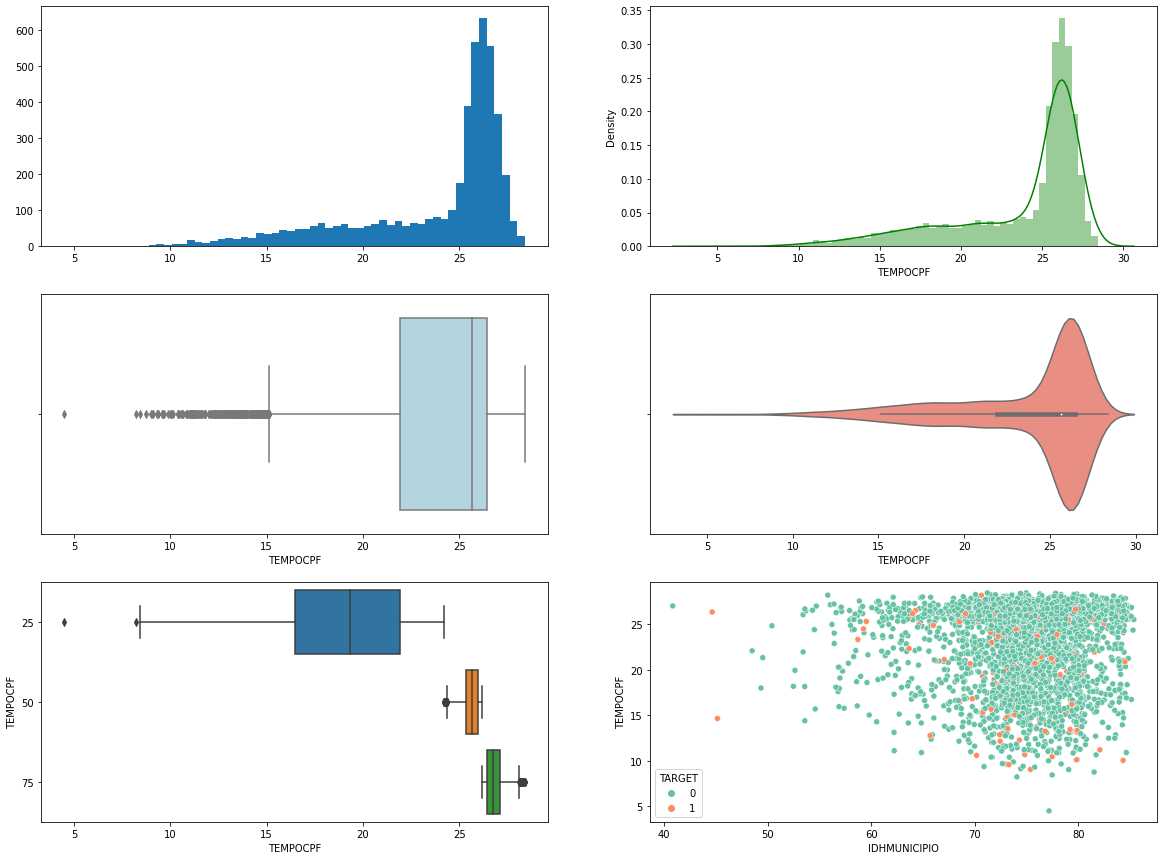

In [ ]:
continuous_variable_plot('TEMPOCPF')

In [ ]:
# Assimetria e Curtose
print(f"Skew: {round(df['TEMPOCPF'].skew(),2)}")
print(f"Kurtosis: {round(df['TEMPOCPF'].kurt(), 2)}")

Skew: -1.45
Kurtosis: 1.23


In [ ]:
df['TEMPOCPF'].describe()

count    4701.000000
mean       23.785968
std         4.044062
min         4.485312
25%        21.919169
50%        25.677517
75%        26.445101
max        28.412590
Name: TEMPOCPF, dtype: float64

**Observações**: Observa-se que os anos de CPF são próximos, oscilando de `4` a `28`. Contudo, o quartil $Q_1$ exemplifica a distribuição dos dados, de maneira que $75\%$ está acima de 21 anos e abaixo do valor máximo citado. <br>

Alguns valores importantes:
- Média ($\mu$) é aproximadamente `23`
- Desvio padrão ($\sigma$) é aproximadamente `4`
- Quartil 1 ($Q_1$) é aproximadamente `21`
- Quartil 2 ($Q_2$), ou mediana ($M_d$) é aproximadamente `25`
- Quartil 3 ($Q_3$) é aproximadamente `26`

Com relação à distribuição, considerando ainda a assimetria e a curtose, observamos que:
- A distribuição **não é normal**, pois $M_o \ne \mu$ e $M_d \ne \mu$
- A distribuição possui **assimetria negativa** ($v < 0$), portando cauda pro lado esquerdo do eixo $x$
- Possui **cauda pro lado negativo** do eixo $x$
- Possui curtose maior que zero ($k > 0$), indicando uma **distribuição leptocúrtica**
- A moda é menor que a mediana, que por sua vez é menor que a média ($M_o < M_d < \mu$)

Por fim, é evidente que os valores acima de $Q_1$ são bem próximos, contudo, a presença de valores baixos (tal qual 4 anos de tempo de CPF) causam uma longa cauda para o lado negativo do eixo $x$.

### Variável 3: `MEDIAIDADECASA`

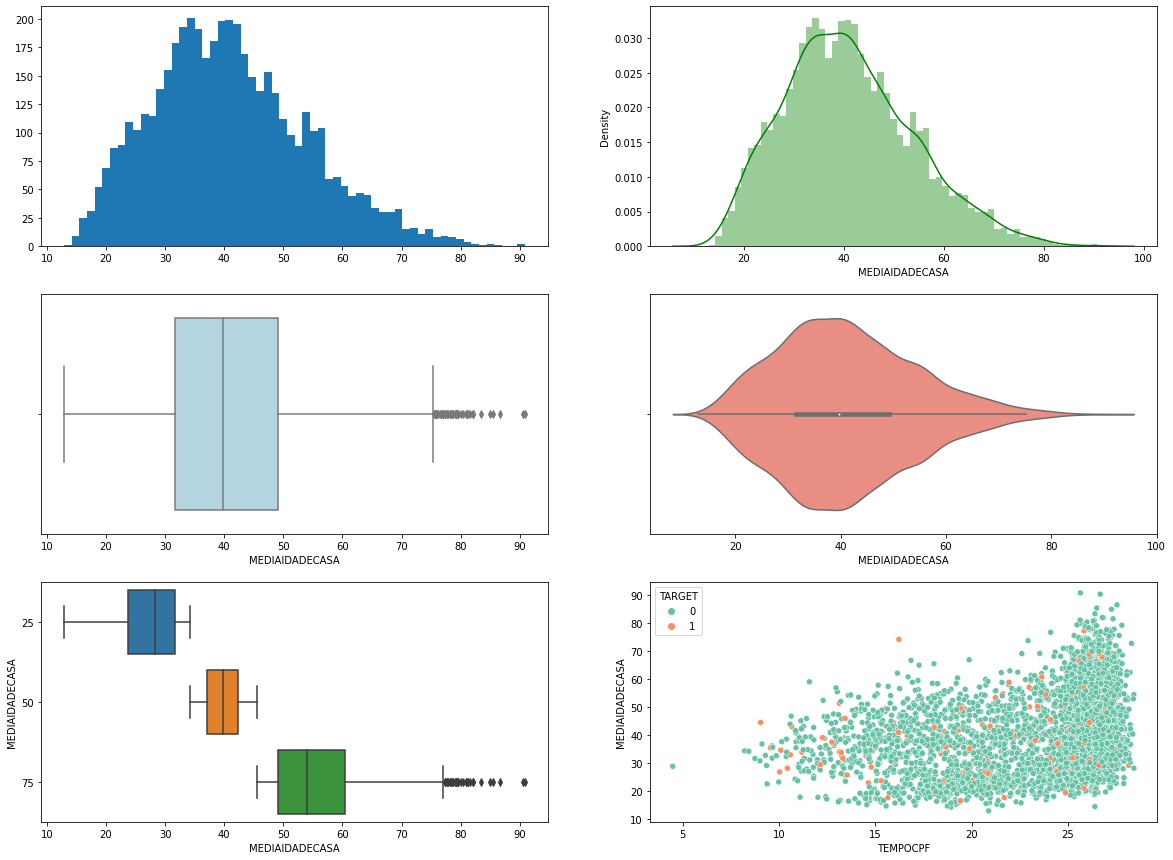

In [ ]:
continuous_variable_plot('MEDIAIDADECASA')

In [ ]:
idades_medias = df['MEDIAIDADECASA'] \
                .map(lambda x: int(x) if str(x) != "nan" else np.nan)
                
int(idades_medias.mode()[0])

39

In [ ]:
# Assimetria e Curtose
print(f"Skew: {round(df['MEDIAIDADECASA'].skew(),2)}")
print(f"Kurtosis: {round(df['MEDIAIDADECASA'].kurt(), 2)}")

Skew: 0.48
Kurtosis: -0.05


In [ ]:
df['MEDIAIDADECASA'].describe()

count    4701.000000
mean       40.983390
std        12.978669
min        12.925138
25%        31.615961
50%        39.770021
75%        49.109574
max        90.881434
Name: MEDIAIDADECASA, dtype: float64

**Observações**: Observa-se que os valores aparentemente são mais próximos de uma distribuição normal em relação às variáveis passadas. Contudo, também é possível observar uma discrepância de valores mínimos e máximos (respectivamente `12` e `90`); contudo, um fato importante é que o quartil $Q_3$ equivale a `49`, representando uma longa distância até o valor máximo supracitado.<br>

Alguns valores importantes:
- Média ($\mu$) é aproximadamente `40`
- Desvio padrão ($\sigma$) é aproximadamente `12`
- Quartil 1 ($Q_1$) é aproximadamente `31`
- Quartil 2 ($Q_2$), ou mediana ($M_d$) é aproximadamente `39`
- Quartil 3 ($Q_3$) é aproximadamente `49`

Com relação à distribuição, considerando ainda a assimetria e a curtose, observamos que:
- A distribuição **é próxima da normal**, pois $M_o \approx \mu$ e $M_d \approx \mu$
- A distribuição possui uma leve **assimetria positiva** ($v < 0$), portando cauda pro lado direito do eixo $x$
- Possui **cauda leve pro lado positivo** do eixo $x$
- A moda é aproximadamente igual à mediana, que por sua vez é aproximadamente igual à média ($M_o \approx M_d \approx \mu$)
- Possui curtose aproximadamente igual à zero ($k \approx 0$), indicando uma **distribuição com tendência mesocúrtica**

### Variável 4: `IDHMUNICIPIO`

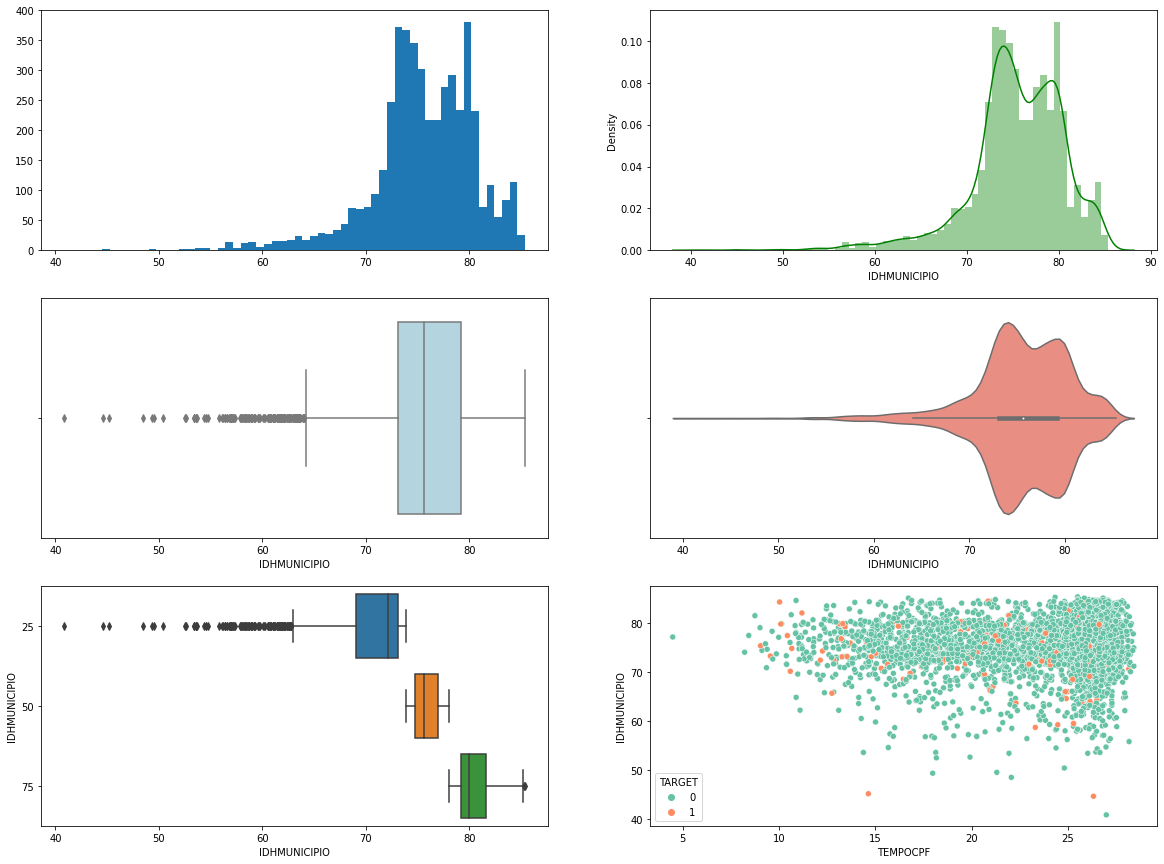

In [ ]:
continuous_variable_plot('IDHMUNICIPIO')

In [ ]:
# Assimetria e Curtose
print(f"Skew: {round(df['IDHMUNICIPIO'].skew(),2)}")
print(f"Kurtosis: {round(df['IDHMUNICIPIO'].kurt(), 2)}")

Skew: -1.16
Kurtosis: 3.26


In [ ]:
df['IDHMUNICIPIO'].describe()

count    4701.000000
mean       75.528801
std         5.036516
min        40.831737
25%        73.113320
50%        75.589261
75%        79.170176
max        85.386056
Name: IDHMUNICIPIO, dtype: float64

**Observações**: Observa-se que a distribuição possui uma cauda para o lado negativo do eixo $x$, apesar de ter um aspecto levemente normal.

Alguns valores importantes:
- Média ($\mu$) é aproximadamente `75`
- Desvio padrão ($\sigma$) é aproximadamente `5`
- Quartil 1 ($Q_1$) é aproximadamente `73`
- Quartil 2 ($Q_2$), ou mediana ($M_d$) é aproximadamente `75`
- Quartil 3 ($Q_3$) é aproximadamente `85`

Com relação à distribuição, considerando ainda a assimetria e a curtose, observamos que:
- A distribuição **não é normal**, pois $M_o \ne \mu$ e $M_d \ne \mu$
- A distribuição possui **assimetria negativa** ($v < 0$), portando cauda pro lado esquerdo do eixo $x$
- Possui **cauda pro lado negativo** do eixo $x$
- Possui curtose maior que zero ($k > 0$), indicando uma **distribuição leptocúrtica**
- A moda é menor que a mediana, que por sua vez é menor que a média ($M_o < M_d < \mu$)

Por fim, podemos notar que os valores dos respectivos quartis são bem próximos, bem como exemplificado pelo baixo valor de desvio-padrão ($\sigma$), se comparado à média ($\mu$).

### Variável 5: `QTDCAMINHAOMUNICIPIO`

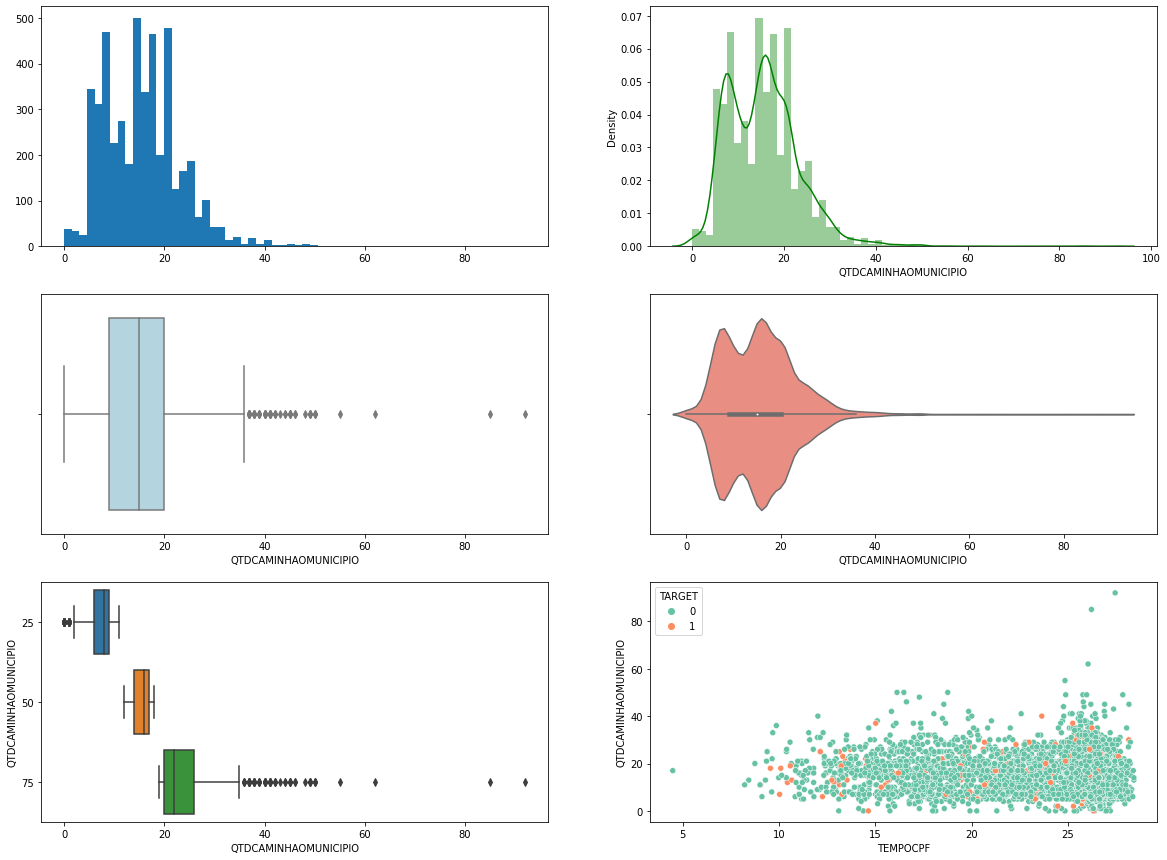

In [ ]:
continuous_variable_plot('QTDCAMINHAOMUNICIPIO')

In [ ]:
# Assimetria e Curtose
print(f"Skew: {round(df['QTDCAMINHAOMUNICIPIO'].skew(),2)}")
print(f"Kurtosis: {round(df['QTDCAMINHAOMUNICIPIO'].kurt(), 2)}")

Skew: 1.09
Kurtosis: 4.57


In [ ]:
df['QTDCAMINHAOMUNICIPIO'].describe()

count    4701.000000
mean       15.457988
std         7.637881
min         0.000000
25%         9.000000
50%        15.000000
75%        20.000000
max        92.000000
Name: QTDCAMINHAOMUNICIPIO, dtype: float64

**Observações**: Notamos uma grande discrepância entre o valor mínimo (`min`), equivalente a `0` e `max`, equivalente a `92`. <br>

Alguns valores importantes:
- Média ($\mu$) é aproximadamente `15`
- Desvio padrão ($\sigma$) é aproximadamente `7`
- Quartil 1 ($Q_1$) é aproximadamente `9`
- Quartil 2 ($Q_2$), ou mediana ($M_d$) é aproximadamente `15`
- Quartil 3 ($Q_3$) é aproximadamente `20`

Com relação à distribuição, considerando ainda a assimetria e a curtose, observamos que:
- A distribuição **não é normal**, pois $M_o \ne \mu$ e $M_d \ne \mu$
- A distribuição possui **assimetria positiva** ($v > 0$), portando cauda pro lado direito do eixo $x$
- Possui **cauda pro lado positivo** do eixo $x$
- Possui curtose maior que zero ($k > 0$), indicando uma **distribuição leptocúrtica**
- A moda é menor que a mediana, que por sua vez é menor que a média ($M_o < M_d < \mu$)
- O desvio padrão ($\sigma$) é próximo da média, porém a maior parte dos dados (até $Q_3$) são muito próximos da média, configurando uma distribuição leptocúrtica

### Variável 6: `FUNCIONARIOPUBLICO`

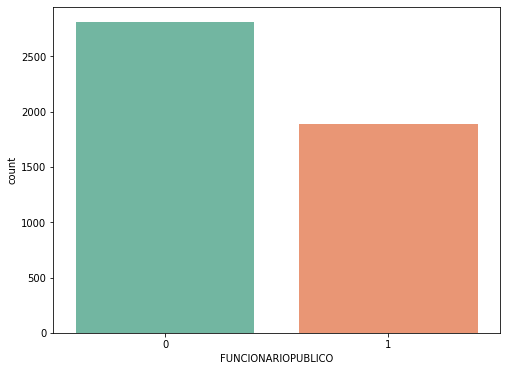

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(df['FUNCIONARIOPUBLICO'], palette='Set2');

In [ ]:
df['FUNCIONARIOPUBLICO'].value_counts()

0    2809
1    1892
Name: FUNCIONARIOPUBLICO, dtype: int64

**Observações**: É evidente uma maioria de indivíduos não funcionários públicos, respectivamente `2809` não atuando em cargos públicos, frente a `1892` que atuam em tais cargos.

### Variável 7: `TARGET`

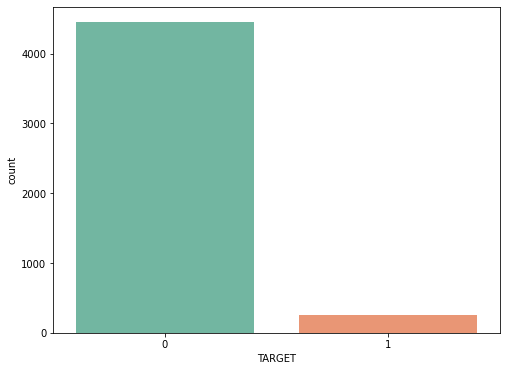

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(df['TARGET'], palette='Set2');

In [ ]:
df['TARGET'].value_counts()

0    4451
1     250
Name: TARGET, dtype: int64

**Observações**: É evidente uma maioria de indivíduos adimplentes (`0`), frente a uma minoria inadimplente (`1`), respectivamente `4451` e `250`.

# Multivariate data analysis

In this section, you should plot at least 8 multivariate visualizations. The key here is to investigate underlying correlations and behaviors in the dataset.
Naturally, as visualizations are being created, we should end up with obvious results, yet, you should find at least **TWO** non-obvious behavior in data.

Please follow these steps for creating your visualizations:
1. State an hypothesis. The key here is to explain why you are choosing those specific variables together and what you are expecting to find.
2. Determine what kind of visualization is the most suited.
3. Report the findings and whether they corroborate or not the aforestated hypothesis.


**Hints**

In this section, make sure you go beyond naive explorations. For instance, try PCA, t-SNE, and even other techniques we have not worked with during the lectures. The key here is to start to develop a critical mindset towards data analysis and our own work.

**Important**

It is strictly forbidden to create multivariate visualizations using variables that were not used in the previous section (univariate analysis).

In [ ]:
df_sample = df_train_full.sample(20000)
dfs_multiv = [df_sample, df_train_full, df]

In [ ]:
def multivariate_analisys(*features: str) -> None:
    """
    Função que realiza uma plotagem multivariada de features
    utilizando regplot

    Params:
        *features: features para realizar a plotagem

    Returns: 
        None
    """

    fig, ax = plt.subplots(1, 3, figsize=(25,5))

    dfs_multiv_titles = ['Sampled', 
                         'Full DataFrame', 
                         'Full Without Missing Values']

    for dataframe, i in zip(dfs_multiv, range(len(dfs_multiv))):

        ax[i].set_title(dfs_multiv_titles[i])
        sns.regplot(dataframe[features[0]],
                    dataframe[features[1]],
                    ax=ax[i],
                    scatter_kws={'s':25, 'color':'lightblue', "alpha":1}, 
                    line_kws={'color': 'orange','lw':2.5}).set(ylim=(0));

In [ ]:
# 21 Variáveis Selecionadas
# 'TEMPOCPF', 'DISTCENTROCIDADE', 'INDICEEMPREGO',
# 'IDHMUNICIPIO', 'MEDIARENDACEP', 'PERCENTSUPERIORCEP', 
# 'MEDIARENDACASA', 'SOMARENDACASA', 'PERCENTPOPZONAURBANA', 
# 'PERCENTMEDIOCEP', 'QTDCAMINHAOMUNICIPIO', 'ESTIMATIVARENDA',
# 'MEDIAIDADECASA', 'PIBMUNICIPIO', 'PERCENTBOLSAFAMILIACEP',
# 'QTDPESSOASCASA', 'QTDDECLARACAOISENTA', 'QTDCELULAR',
# 'BOLSAFAMILIACASA', 'FUNCIONARIOPUBLICO', 'TARGET'

## Combinação 1: `TEMPOCPF` e `MEDIARENDACASA`

> *Maiores tempos de CPF de um indivíduo estão associados com maiores médias de renda da casa que essa pessoa vive?*

**$H_0$**: Indivíduos que possuem maiores tempos de CPF tendem a possuir uma renda média familiar maior. <br>
**$H_A$**: Indivíduos que possuem maiores tempos de CPF tendem a possuir uma renda média familiar menor. <br><br>

<p align="justify"><b>Justificativa</b>: É intuitivo pensar que, na medida que o tempo de CPF de um indivíduo é maior, este possui mais probabilidade de ser casado e possuir uma família, logo possuindo na média uma renda superior que individualmente. Também podemos pensar sob o viés de que esta pessoa teve mais tempo para se estabilizar financeiramente em relação a uma pessoa mais jovem. Considerando o caráter evidente da hipótese, consideramos como uma hipótese óbvia.</p>

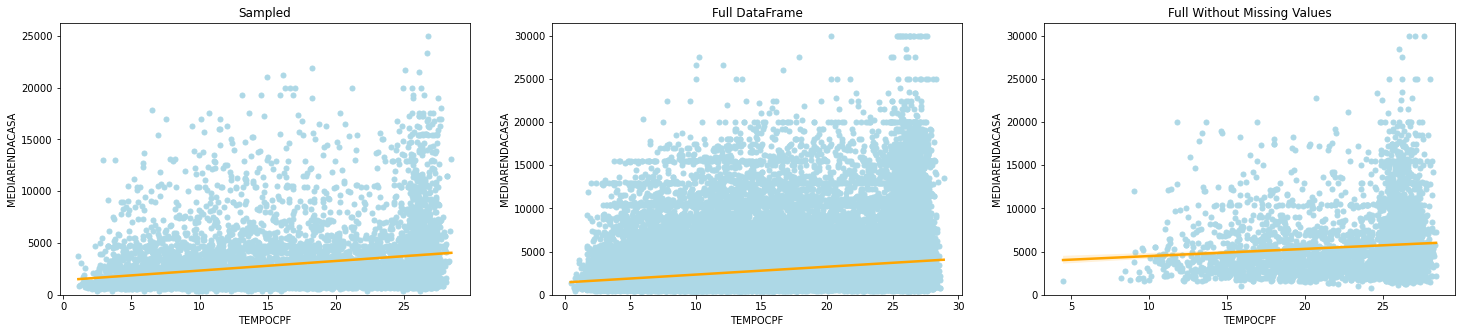

In [ ]:
multivariate_analisys('TEMPOCPF', 'MEDIARENDACASA')

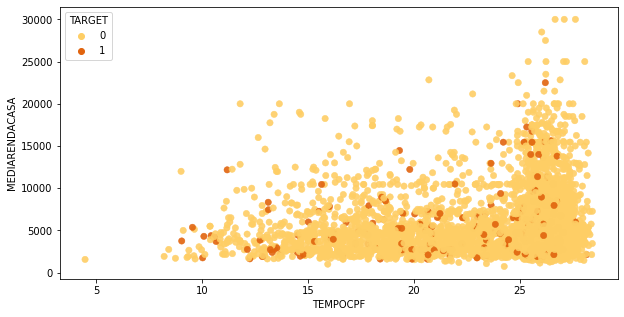

In [ ]:
sns.scatterplot(data=df, 
                x='TEMPOCPF',
                y='MEDIARENDACASA',
                hue='TARGET',
                s=40,
                palette='YlOrBr',
                alpha=.9,
                edgecolor=None);

**Conclusão**: Observamos que, para os três conjuntos de dados, existe uma inclinação na linha de regressão, indicando uma tendência de pessoas com tempos de CPF próximos de 25 anos possuírem os maiores rendas médias; concluímos, portanto, que a hipótese nula ($H_0$) mostrou-se verdadeira.

## Combinação 2: `IDHMUNICIPIO` e `PIBMUNICIPIO`

> *Quanto maior o PIB per capita de um município, maior tende a ser seu IDH?*

**$H_0$**: Municípios que possuem maiores valores de PIB per capita tendem a possuir maiores valores de IDH. <br>
**$H_A$**: Municípios que possuem maiores valores de PIB per capita tendem a possuir menores valores de IDH. <br><br>

<p align="justify"><b>Justificativa</b>: É intuitivo pensar que, na medida que o PIB per capita de um município é maior, o IDH também tende a ser mais alto, uma vez que existem condições financeiras para se investir em educação, saúde, lazer, entre outros. Considerando a justificativa, classificamos essa hipótese como sendo óbvia.</p>

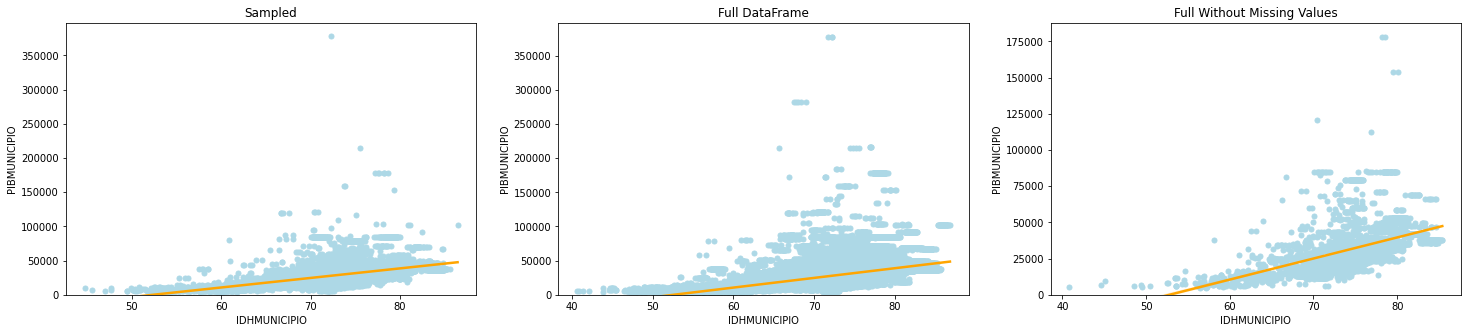

In [ ]:
multivariate_analisys('IDHMUNICIPIO', 'PIBMUNICIPIO')

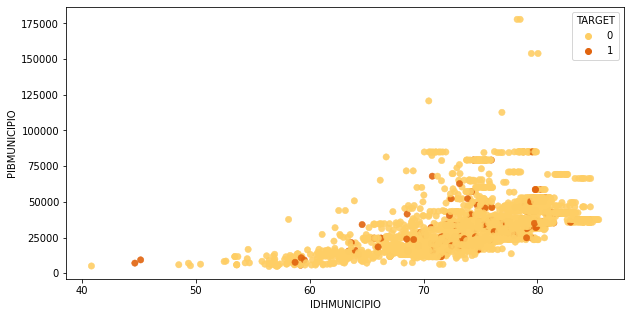

In [ ]:
sns.scatterplot(data=df, 
                x='IDHMUNICIPIO',
                y='PIBMUNICIPIO',
                hue='TARGET',
                s=40,
                palette='YlOrBr',
                alpha=.9,
                edgecolor=None);

**Conclusão**: Observamos que existe uma proporcionalidade direta entre as variáveis, ou seja, na medida que os valores de PIB per capita do município crescem, o IDH também tende a ser maior; observamos a linha da regressão como sendo crescente. Nesse caso, aceitamos a hipótese nula ($H_0$).

## Combinação 3: `PERCENTBOLSAFAMILIACEP` e `PERCENTSUPERIORCEP`

> *Quanto maior o percentual de bolsa família em um CEP, menor tende a ser o percentual de pessoas cursando o ensino superior?* 

**$H_0$**: Quanto maior o percentual de bolsa família em um CEP, menor tende a ser o percentual de pessoas cursando o ensino superior. <br>
**$H_A$**: Quanto maior o percentual de bolsa família em um CEP, maior tende a ser o percentual de pessoas cursando o ensino superior. <br><br>

<p align="justify"><b>Justificativa</b>: É intuitivo pensar que, na medida que o percentual de pessoas que recebem bolsa família em um CEP é elevado, essa região tem uma alta probabilidade de ser mais pobre, uma vez que mais pessoas demandam de assitência. Considerando as condições de possível dificuldade financeira, é provável que o percentual de pessoas cursando o ensino superior tenda a ser menor em detrimento de regiões menos pobres.</p>

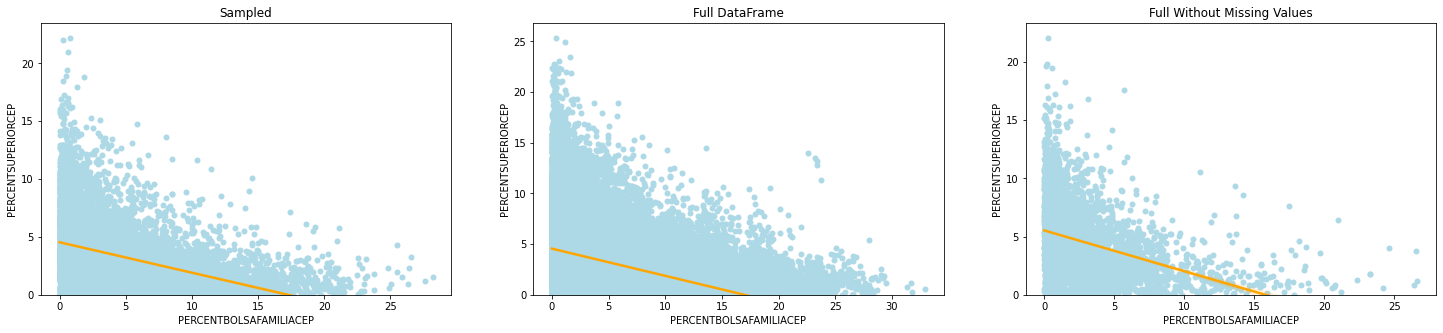

In [ ]:
multivariate_analisys('PERCENTBOLSAFAMILIACEP', 'PERCENTSUPERIORCEP')

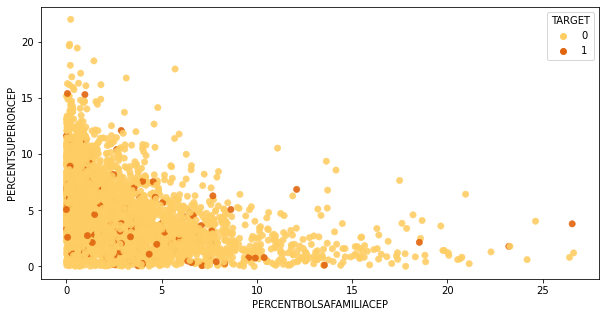

In [ ]:
sns.scatterplot(data=df, 
                x='PERCENTBOLSAFAMILIACEP',
                y='PERCENTSUPERIORCEP',
                hue='TARGET',
                s=40,
                palette='YlOrBr',
                alpha=.9,
                edgecolor=None);

**Conclusão**: Observamos que existe uma proporcionalidade inversa entre o percentual de CEPs que recebem o bolsa família e o percentual de pessoas cursando o ensino superior, tal como indicado pela linha de regressão linear decrescente. Nesse caso, aceitamos a hipótese nula ($H_0$). Como a hipótese é intuitiva, consideramos esse item como sendo óbvio.

## Combinação 4: Todos os Atributos Escolhidos com `t-SNE`

> *Existe uma proporcionalidade direta entre todos os atributos, ou seja, na medida que um cresce, todos crescem?*

**$H_0$**: Existe uma relação linear entre os atributos escolhidos para análise univariada, de modo que todos são simultaneamente diretamente proporicionais. <br>
**$H_A$**: Não existe uma relação linear entre os atributos escolhidos para análise univariada, de modo que todos não são simultaneamente diretamente proporcionais. <br><br>

<p align="justify"><b>Justificativa</b>: Podemos supor, ingenuamente, que todos os atributos são linearmente relacionados, podendo ser diretamente proporcionais (na medida que um cresce em valor, todos os demais crescem), ou então inversamente proporcionais. Essa relação poderia fazer sentido caso todos os atributos fossem semelhantes, tal como soma da renda, média da renda, entre outros.</p>

In [ ]:
tsne = TSNE(n_components=2,
            perplexity=40,
            n_iter=1000)

X_transformado = tsne.fit_transform(df.drop(['TARGET'], 
                                            axis=1))

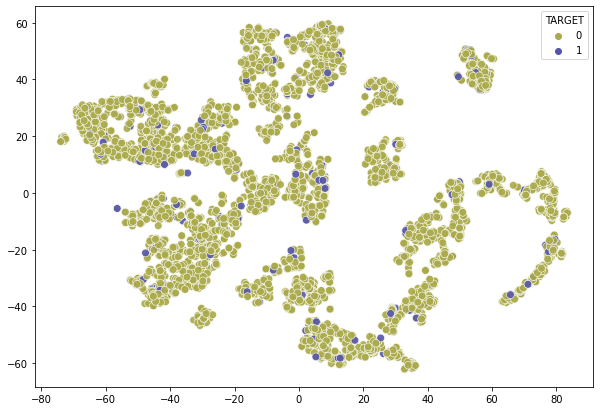

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(X_transformado[:,0], 
                X_transformado[:,1],
                hue=df['TARGET'],
                s=60,
                palette='gist_stern_r',
                alpha=.9)
plt.show()

<p align="justify"><b>Conclusão</b>: Observamos que os dados, distribuídos em um gráfico de dispersão, não apresentam uma relação linear. Podemos observar que os pontos seguem um movimento a primeira vista "aleatório", pois essa relação não é facilmente observada em duas dimensões. Em ambos casos (adimplência e inadimplência), essa relação não é evidente. Nesse caso, é possível que existam variáveis diretamente proporcionais e inversamente proporcionais simultaneamente em nossa base de dados, bem como relações específicas entre os atributos. Rejeitamos a nossa hipótese nula ($H_0$) e aceitamos a hipótese alternativa ($H_A$). Considerando a ingenuidade da hipótese, consideramos ela como sendo óbvia.</p>

## Combinação 5: Todos os Atributos Escolhidos com `PCA`

> *Existe uma proporcionalidade inversa entre todos os atributos, ou seja, na medida que um cresce, todos decrescem?*

**$H_0$**: Existe uma relação linear entre os atributos escolhidos para análise univariada, de modo que todos são simultaneamente inversamente proporicionais. <br>
**$H_A$**: Não existe uma relação linear entre os atributos escolhidos para análise univariada, de modo que todos não são simultaneamente inversamente proporicionais. <br><br>

<p align="justify"><b>Justificativa</b>: Podemos supor, ingenuamente, que todos os atributos são linearmente relacionados, podendo ser diretamente proporcionais (na medida que um cresce em valor, todos os demais crescem), ou então inversamente proporcionais.</p>

In [ ]:
scaler = StandardScaler()
df_pca = pd.DataFrame()

df_pca_reduced = PCA(n_components=2, 
                     random_state=42). \
                     fit_transform(scaler.fit_transform(df))

df_pca['PCA'] = np.reshape(df_pca_reduced,(1,-1))[0]
df_pca['TARGET'] = df['TARGET']

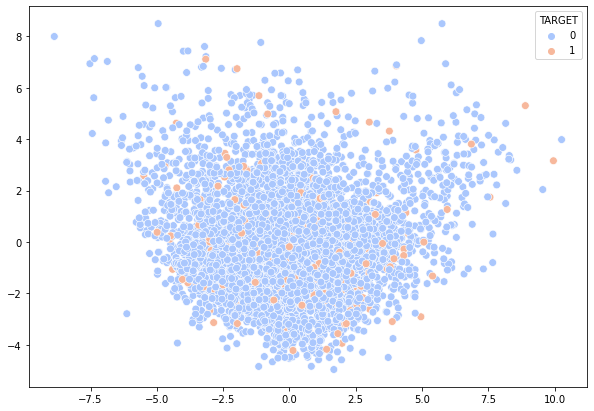

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df,
                x=df_pca_reduced[:,0], 
                y=df_pca_reduced[:,1],
                hue='TARGET',
                s=60,
                palette='coolwarm');

<p align="justify"><b>Conclusão</b>: Observamos que os dados, distribuídos em um gráfico de dispersão, não apresentam uma relação linear. Podemos observar que os pontos seguem um movimento a primeira vista "aleatório", pois essa relação não é facilmente observada em duas dimensões. Em ambos casos (adimplência e inadimplência), essa relação não é evidente. Nesse caso, é possível que existam variáveis diretamente proporcionais e inversamente proporcionais simultaneamente em nossa base de dados, bem como relações específicas entre os atributos. Rejeitamos a nossa hipótese nula ($H_0$) e aceitamos a hipótese alternativa ($H_A$). Considerando a ingenuidade da hipótese, consideramos ela como sendo óbvia.</p>

## Combinação 6: `MEDIARENDACASA`, `MEDIARENDACEP` e `ESTIMATIVARENDA`

> *A variável de Estimativa de Renda representa de fato uma estimativa fiél à renda média da casa do indivíduo?*

**$H_0$**: A variável de Estimativa de Renda representa de fato uma estimativa fiél à renda média da casa do indivíduo. <br>
**$H_A$**: A variável de Estimativa de Renda não representa de fato uma estimativa fiél à renda média da casa do indivíduo. <br><br>

<p align="justify"><b>Justificativa</b>: É um questionamento válido sobre a estimativa de renda, comparada à renda média do indivíduo, se essa representa de fato uma informação fiél a primeira.</p>

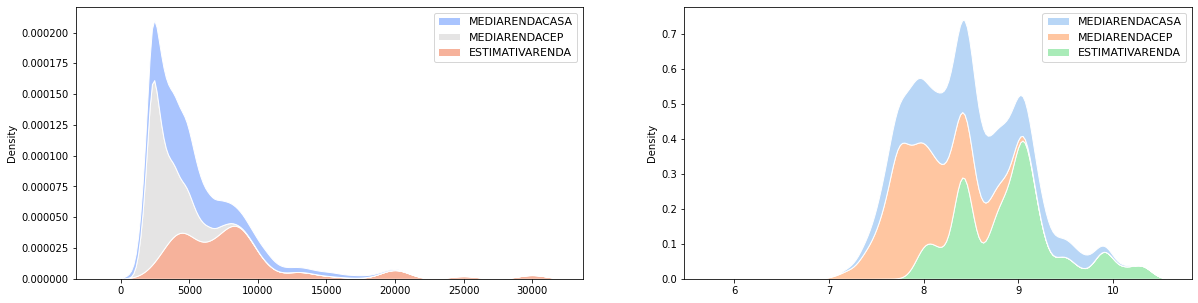

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

palettes = ['coolwarm', 'pastel']

plt.rc('font', size=11);

for i in range(2):
    if i == 0:
        sns.kdeplot(data=df[['MEDIARENDACASA',
                             'MEDIARENDACEP',
                             'ESTIMATIVARENDA']],
                    multiple='stack',
                    palette=palettes[i],
                    edgecolor='white',
                    ax=ax[i]);
    else:
        plt.rc('font', size=11);
        sns.kdeplot(data=np.log(df)[['MEDIARENDACASA',
                                     'MEDIARENDACEP',
                                     'ESTIMATIVARENDA']],
                    multiple='stack',
                    palette='pastel',
                    edgecolor='white');

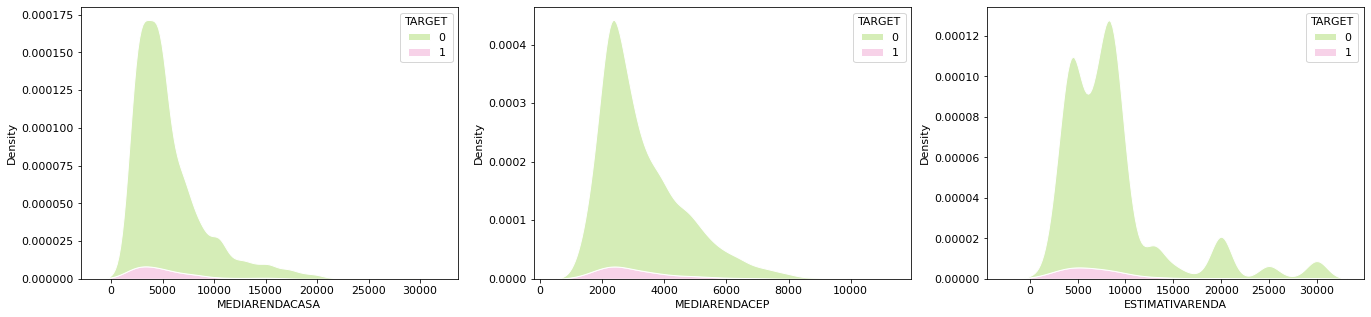

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(23,5))

vars = ['MEDIARENDACASA', 'MEDIARENDACEP', 'ESTIMATIVARENDA']

plt.rc('font', size=11);

for i in range(3):
        plt.rc('font', size=11);
        plt.rc('font', size=11);
        sns.kdeplot(data=df,
                    x=vars[i],
                    hue='TARGET',
                    multiple='stack',
                    palette='PiYG_r',
                    ax=ax[i],
                    edgecolor='white');

<p align="justify"><b>Conclusão</b>: Comparando as distribuições e tranformações das distribuições ($log$), bem como a proporção de adimplentes e inadimplentes ao longo das variáveis, concluímos que a <code>ESTIMATIVARENDA</code> é uma boa representatividade das demais variáveis de renda descritas, no sentido de apresentar comportamentos semelhantes. Nesse caso, aceitamos a hipótese nula ($H_0$).</p>

## Combinação 7: `PERCENTBOLSAFAMILIACEP` e `QTDCAMINHAOMUNICIPIO`

> *Quanto maior o percentual de bolsa família de uma região, maior tende a ser a quantidade de caminhões no município?*

**$H_0$**: Quanto maior o percentual de bolsa família de um CEP, maior tende a ser a quantidade de caminhões daquele município. <br>
**$H_A$**: Quanto maior o percentual de bolsa família de um CEP, menor tende a ser a quantidade de caminhões daquele município. <br><br>

<p align="justify"><b>Justificativa</b>: Podemos supor que, considerando que um caminhoneiro recebe na média dois salário mínimos (aproximadamente), que as regiões com maiores percentuais de bolsa família também correspondem a municípios com um maior número de caminhoneiros, que por sua vez recebem deste benefício considerando suas famílias. Por outro lado, podemos também considerar que, dado que o bolsa família é destinado a pessoas mais pobres, essas provavelmente não teriam poder aquisitivo para adquirir um caminhão. Considerando os fatores mencionado acima, classificamos essa hipótese como não óbvia, uma vez que é evidente que podemos interpretar a situação por mais de uma maneira (contraditória) de uma forma coerente.</p>

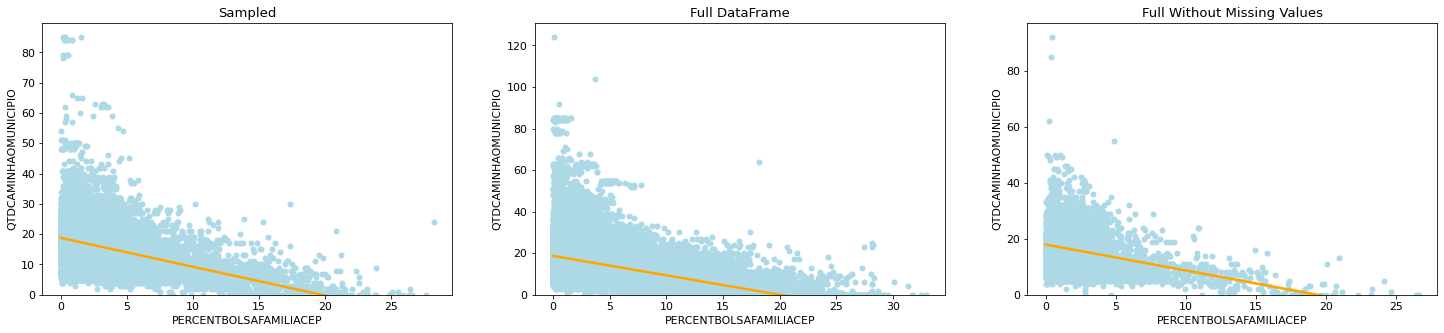

In [ ]:
multivariate_analisys('PERCENTBOLSAFAMILIACEP', 'QTDCAMINHAOMUNICIPIO')

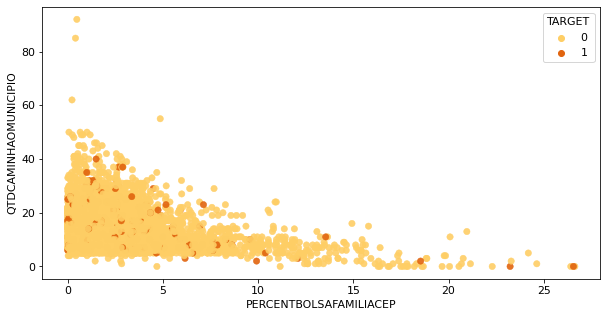

In [ ]:
sns.scatterplot(data=df, 
                x='PERCENTBOLSAFAMILIACEP',
                y='QTDCAMINHAOMUNICIPIO',
                hue='TARGET',
                s=40,
                palette='YlOrBr',
                alpha=.9,
                edgecolor=None);

<p align="justify"><b>Conclusão</b>: É notável que existe uma proporcionalidade inversa entre as variáveis, como demostrado pela linha decrescente da regressão linear. Nesse caso, aceitamos a hipótese alternativa ($H_A$).</p>

## Combinação 8: `FUNCIONARIOPUBLICO`, `BOLSAFAMILIACASA` e `TARGET`

> *Caso o indivíduo possua bolsa família na casa e não seja funcionário público,este possui uma probabilidade elevada de inadimplência?*

**$H_0$**: Caso o indivíduo possua bolsa família na casa e não seja funcionário público,este possui uma probabilidade elevada de inadimplência (maior que a média). <br>
**$H_A$**: Caso o indivíduo possua bolsa família na casa e não seja funcionário público, este não possui uma probabilidade elevada de inadimplência (maior que a média) <br><br>

<p align="justify"><b>Justificativa</b>: Podemos supor que indivíduos que recebem o bolsa família possuem uma renda mais baixa, logo possuem uma maior probabilidade de inadimplência, visto que também não são funcionários públicos (visto que em média um funcionário público recebe um salário elevado se comparado ao salário mínimo). Por outra via, podemos supor que a porcentagem de indivíduos que recebem tal benefício é baixa, e logo que ainda que a taxa de inadimplência seja de 100% para quem recebe este benefício, a probabilidade (considerando que a probabilidade é a proporção entre ocorrências/eventos) ainda estaria abaixo da média. Considerando os fatores mencionado acima, classificamos essa hipótese como não óbvia, uma vez que é evidente que podemos interpretar a situação por mais de uma maneira (contraditória) de uma forma coerente.</p>

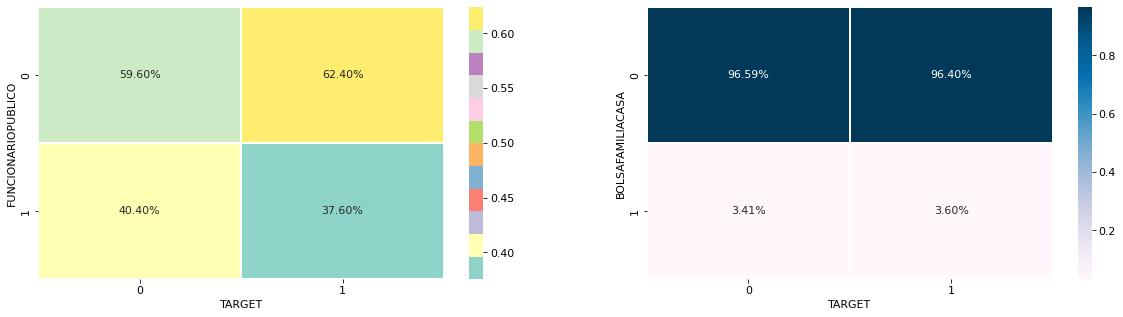

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

cmaps = ['Set3', 'PuBu']
vars = ['FUNCIONARIOPUBLICO', 'BOLSAFAMILIACASA']

for i in range(2):
    ctab = pd.crosstab(df[vars[i]], 
                       df['TARGET'], 
                       normalize='columns');

    sns.heatmap(ctab, 
                annot=True, 
                fmt='.2%', 
                cmap=cmaps[i],
                ax=ax[i],
                linewidths=1);

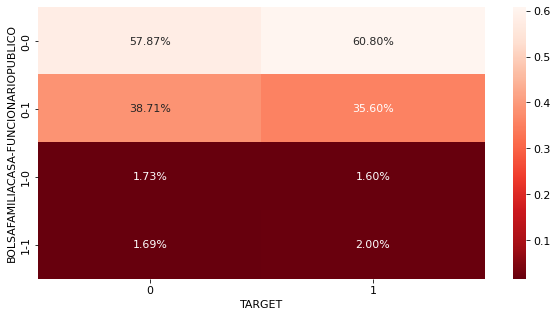

In [ ]:
ctab = pd.crosstab([df['BOLSAFAMILIACASA'], 
                    df['FUNCIONARIOPUBLICO']], 
                    df['TARGET'], 
                    normalize='columns')

sns.heatmap(ctab, annot=True, fmt='.2%', cmap='Reds_r');

<p align="justify"><b>Conclusão</b>: Podemos observar que a porcentagem de pessoas que recebem o bolsa família é não são funcionárias públicas e que são inadimplentes é de $1,60\%$, em contrapartida de $1,73\%$ que não são inadimplentes. Considerando o contraste com o valor máximo de $60,80\%$ para pessoas inadimplentes que não recebem o benefício e nem são funcionárias públicas, negamos a nossa hipótese nula e aceitamos a hipótese alternativa ($H_A$).</p>

## Combinação 9: `FUNCIONARIOPUBLICO` e `TARGET`

> *Caso o indivíduo seja funcionário público, este possui a menor porcentagem de inadimplência em relação aos não funcionários públicos?*

**$H_0$**: Caso o indivíduo seja funcionário público, este possui a menor porcentagem de inadimplência em relação aos não funcionários públicos. <br>
**$H_A$**: Caso o indivíduo seja funcionário público, este não possui a menor porcentagem de inadimplência em relação aos não funcionários públicos <br><br>

<p align="justify"><b>Justificativa</b>: Considerando que um indvíduo que é funcionário público recebe um salário acima da média, podemos supor que este possuirá uma porcentagem de inadimplência menor que os indivíduos que não são funcionários públicos. Por outra via, assim como na hipótese passada, podemos considerar que o número desses indivíduos seja muito baixo, e que 100% dos casos é inadimplente. Considerando esses aspectos, classificamos essa hipótese como não óbvia, apesar de mais simples que as demais hipóteses não óbvias.</p>

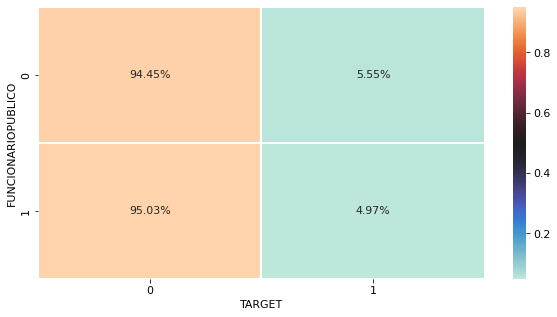

In [ ]:
ctab = pd.crosstab(df['FUNCIONARIOPUBLICO'], 
                   df['TARGET'], 
                   normalize='index')

sns.heatmap(ctab, 
            annot=True, 
            fmt='.2%', 
            cmap='icefire', 
            linewidths=1);

<p align="justify"><b>Conclusão</b>: Podemos observar que a porcentagem de inadimplência para funcionários públicos é de fato menor em relação aos não funcionários públicos, nesse caso nos levando a aceitar nossa hipótese nula ($H_0$). Contudo, os valores são muito próximos, respectivamente $5,55\%$ e $4,97\%$ para inadimplência entre funcionário e não funcionários públicos, em relação às respectivas porcentagem de adimplência. Nesse caso, concluímos que não existem informações suficientes e significativas para aceitarmos ou recusarmos as hipóteses. </p>

## *Extra*: Visualização Bivariada das 6 primeiras Variáveis Escolhidas

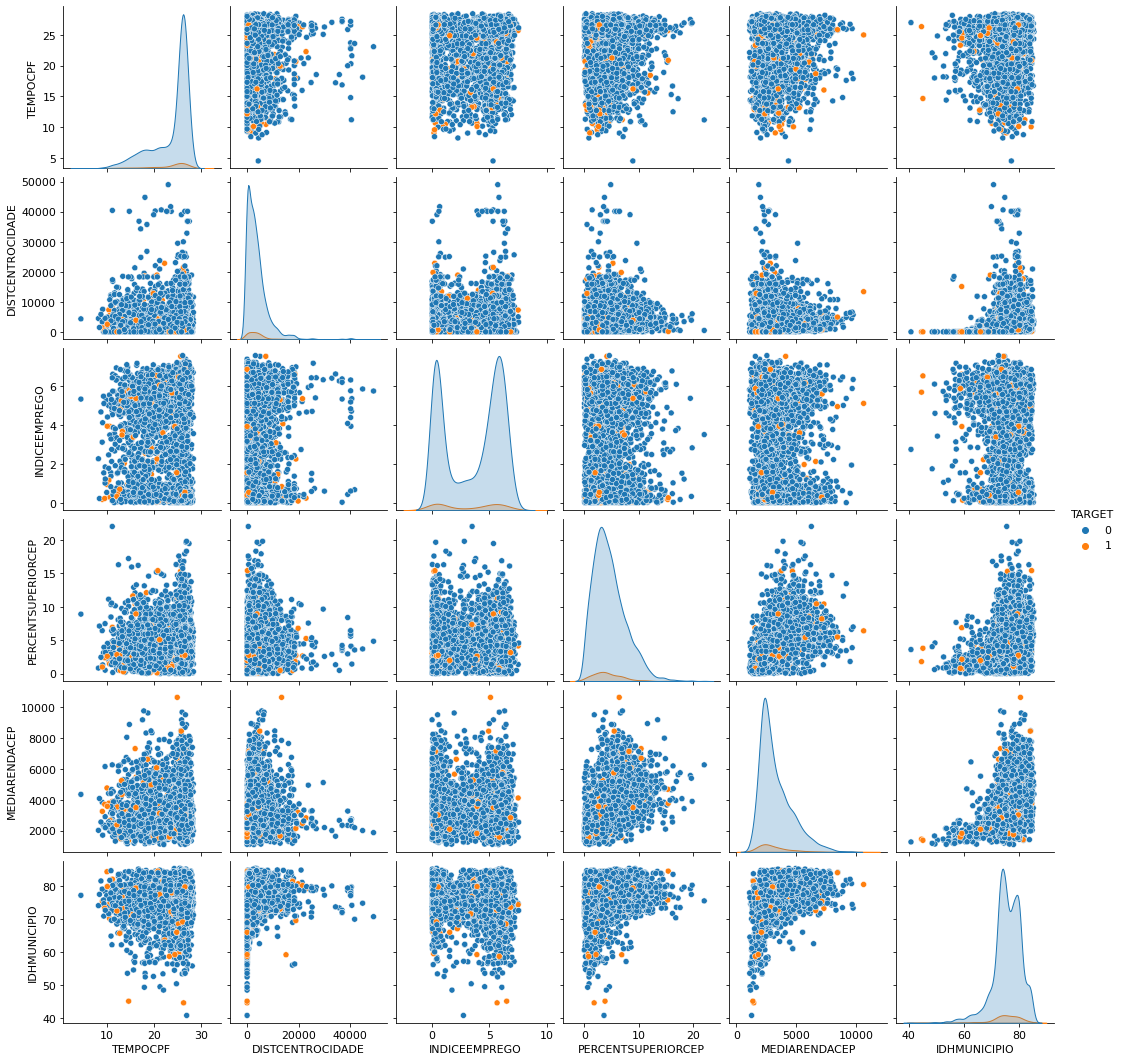

In [ ]:
df_vars = pd.DataFrame()
df_vars['TARGET'] = df['TARGET']
for var in df.columns.values:
    if var in interest_variables[:6]:
        df_vars[var] = df[var]

sns.pairplot(df_vars, 
             hue='TARGET');

# Final Plots

In this section, you need to enhance 3 multivariate visualizations that were presented in the previous section of the report.
The key here is to enhance these visualizations with the goal of presenting them for an audience that is not familiar with the dataset used or with data analysis.
**Therefore, make sure that its size, colors, textures, etc, are appropriate are convey the right information to the audience.**

For your final plots, make sure you follow these steps:
1. Present the plot
2. Provide a description of the visualization, including the main findings that we can extract from it


**Hint: take a look at the checklist also made available based on the work of Evergreen.**

In [ ]:
def enhanced_plot(df: pd.DataFrame,
                  x: str,
                  y: str,
                  order: List[str],
                  labels: List[str],
                  palette: str='Reds_r',
                  alpha: int=.9,
                  ci: str='sd',
                  height: float=7.5) -> None:
    """
    Função que gera um plotagem seguindo as boas práticas de visualização
    de dados, utilizando um catplot do seaborn.

    Params:
        df: DataFrame
        x: primeiro atributo do DataFrame
        y: segundo atributo do DataFrame
        order: labels de intervalo para os valores do eixo x
        labels: labels para os eixos, respectivamente: eixo x,
                eixo y e título da figura
        palette: paleta do cores
        alpha: opacidade da figura
        ci: linha de outliers
        height: tamanho da figura

    Returns: None
    """
    
    plt.rc('font', size=16);
    sns.set_style(style='white')

    # palette alternativa: icefire_r
    plot = sns.catplot(data=df_plot, 
                       kind='bar',
                       x=x, 
                       y=y,
                       ci=ci, 
                       palette=palette,
                       alpha=alpha,
                       height=height,
                       order=order); 

    plot.despine(left=True);
    plot.set_axis_labels(labels[0], 
                         labels[1]);

    plot.fig.subplots_adjust(top=0.85);
    plot.fig.subplots_adjust(right=1.2);
    plot.fig.suptitle(labels[2], 
                      fontsize=19.2);

## Visualização 1: `TEMPOCPF` e `MEDIARENDACASA`

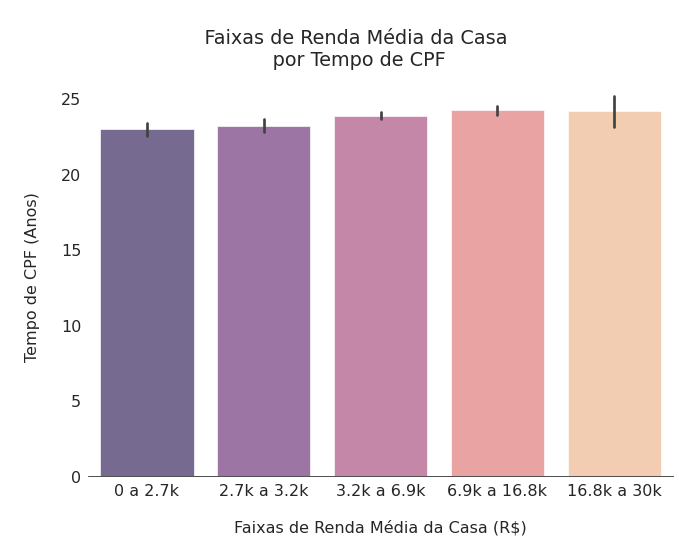

In [ ]:
df_plot = pd.DataFrame()

q15 = int(df['MEDIARENDACASA'].quantile(q=.15))
q25 = int(df['MEDIARENDACASA'].quantile(q=.25))
q50 = int(df['MEDIARENDACASA'].quantile(q=.5))
q75 = int(df['MEDIARENDACASA'].quantile(q=.75))
q98 = int(df['MEDIARENDACASA'].quantile(q=.98))
m = int(df['MEDIARENDACASA'].max())

def mediarendacasa_interval(row):

    if row['MEDIARENDACASA'] <= q15:
        return f'0 a {round((q15/1e3),1)}k'

    elif q15 < row['MEDIARENDACASA'] <= q25:
        return f'{round((q15/1e3),1)}k a {round((q25/1e3),1)}k'

    elif q25 < row['MEDIARENDACASA'] <= q75:
        return f'{round((q25/1e3),1)}k a {round((q75/1e3),1)}k'

    elif q75 < row['MEDIARENDACASA'] <= q98:
        return f'{round((q75/1e3),1)}k a {round((q98/1e3),1)}k'
        
    return f'{round((q98/1e3),1)}k a {int((m/1e3))}k'

# Gerando a coluna com os valores de faixa para a média de renda
df_plot['TEMPOCPF'] = df['TEMPOCPF']
df_plot['MEDIARENDACASA_INTERVAL'] = df.apply(lambda row: \
                                                     mediarendacasa_interval(row), 
                                                     axis=1)

# Labels para a plotagem
order = [f'0 a {round((q15/1e3),1)}k',
         f'{round((q15/1e3),1)}k a {round((q25/1e3),1)}k', 
         f'{round((q25/1e3),1)}k a {round((q75/1e3),1)}k', 
         f'{round((q75/1e3),1)}k a {round((q98/1e3),1)}k', 
         f'{round((q98/1e3),1)}k a {int((m/1e3))}k']
labels= ['\nFaixas de Renda Média da Casa (R$)\n',
         '\nTempo de CPF (Anos)\n',
         '\n' + ' '*20 + 'Faixas de Renda Média da Casa\n' + \
         ' '*20 + ' por Tempo de CPF']

enhanced_plot(df=df_plot,
              x='MEDIARENDACASA_INTERVAL',
              y='TEMPOCPF',
              order=order,
              labels=labels,
              palette='magma',
              alpha=.65,
              ci=99)

## Visualização 2: `IDHMUNICIPIO` e `PIBMUNICIPIO`

<p align="justify">Visualização aprimorada da combinação de atributos 2. O gráfico apresentado na visualização multivariada foi do tipo <code>regplot</code>, com ambas variáveis nos eixos $x$ e $y$, respectivamente. Nesse gráfico, podemos ver uma relação diretamente proporcional entre o PIB per capita e o IDH do município, através da linha de regressão linear sobre os pontos plotados. Nessa visualização aprimorada, transformamos a variável numérica <code>IDHMUNICIPIO</code> para categórica, através da geração de faixas de valor de IDH.</p>

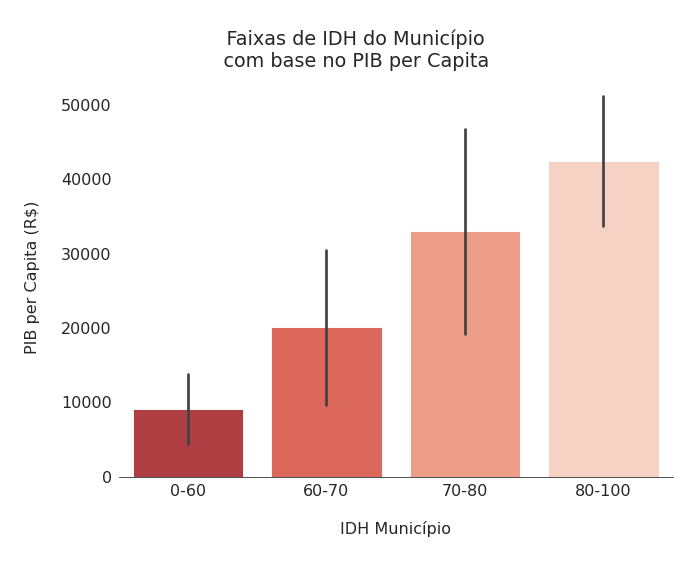

In [ ]:
df_plot = pd.DataFrame()

def idh_interval(row):
    if 50 < row['IDHMUNICIPIO'] <= 60:
        return '0-60'
    elif 60 < row['IDHMUNICIPIO'] <= 70:
        return '60-70'
    elif 70 < row['IDHMUNICIPIO'] <= 80:
        return '70-80'
    return '80-100'

# Gerando a coluna com os valores de faixa para o IDH
df_plot['PIBMUNICIPIO'] = df['PIBMUNICIPIO']
df_plot['IDH_INTERVAL'] = df.apply(lambda row: idh_interval(row), 
                                          axis=1)

# Labels para a plotagem
order = ['0-60', '60-70', '70-80', '80-100']
labels= ['\nIDH Município\n',
         '\nPIB per Capita (R$)\n',
         '\n' + ' '*20 + 'Faixas de IDH do Município\n' + \
         ' '*20 + 'com base no PIB per Capita']

enhanced_plot(df=df_plot,
              x='IDH_INTERVAL',
              y='PIBMUNICIPIO',
              order=order,
              labels=labels)

<p align="justify"><b>Descrição da Visualização</b>: Assim como no gráfico <code>regplot</code>, onde era possível observar uma proporção direta entre ambas variáveis, o gráfico aprimorado acima também permite tal observação, de maneira que as barras crescem na medida que o PIB aumenta. Assim como no gráfico original, podemos observar a dispersão de <i>outliers</i>, nesse caso com base nas linhas acima das barras. No caso do gráfico de dispersão, podemos observar que os <i>outliers</i> mais expressivos se encontram na última faixa (80-100), e no gráfico acima a linha dessa respectiva faixa atinge o valor máximo no eixo $y$.

## Visualização 3: `PERCENTBOLSAFAMILIACEP` e `PERCENTSUPERIORCEP`

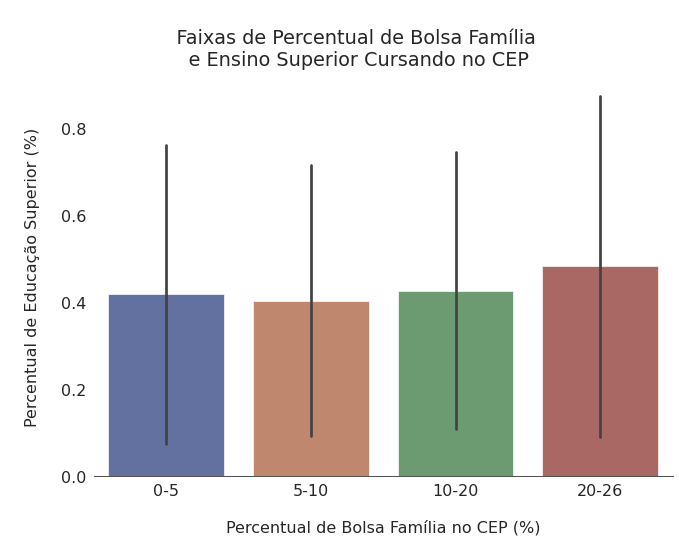

In [ ]:
df_plot = pd.DataFrame()

def bolsafamiliacep_interval(row):
    if row['PERCENTBOLSAFAMILIACEP'] <= 5:
        return '0-5'
    elif 5 < row['PERCENTBOLSAFAMILIACEP'] <= 10:
        return '5-10'
    elif 10 < row['PERCENTBOLSAFAMILIACEP'] <= 20:
        return '10-20'
    return '20-26'

# Gerando a coluna com os valores de faixa para o IDH
df_plot['PERCENTDOUTORADOCEP'] = df['PERCENTDOUTORADOCEP']
df_plot['PERCENTBOLSAFAMILIACEP_INTERVAL'] = df.apply(lambda row: \
                                                      bolsafamiliacep_interval(row), 
                                                      axis=1)

# Labels para a plotagem
order = ['0-5', '5-10', '10-20', '20-26']
labels= ['\nPercentual de Bolsa Família no CEP (%)\n',
         '\nPercentual de Educação Superior (%)\n',
         '\n' + ' '*20 + 'Faixas de Percentual de Bolsa Família\n' + \
         ' '*20 + ' e Ensino Superior Cursando no CEP']

enhanced_plot(df=df_plot,
              x='PERCENTBOLSAFAMILIACEP_INTERVAL',
              y='PERCENTDOUTORADOCEP',
              order=order,
              labels=labels,
              palette='dark',
              alpha=.65)

## Visualização 4: `FUNCIONARIOPUBLICO` e `TARGET`

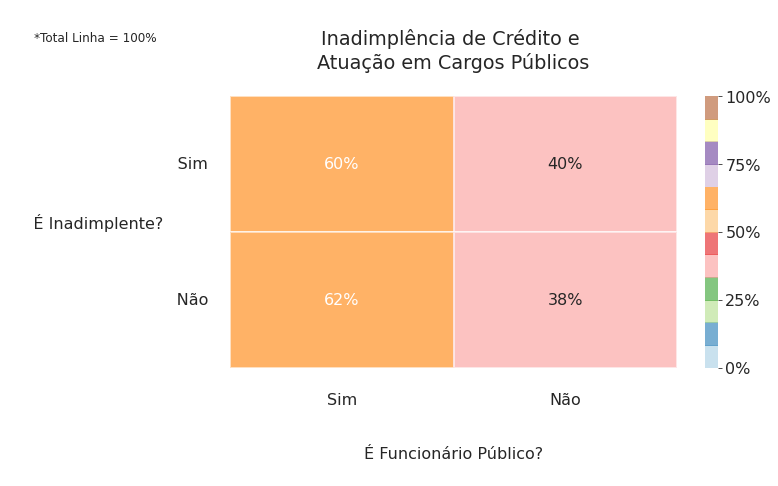

In [ ]:
ctab = pd.crosstab(df['TARGET'], 
                   df['FUNCIONARIOPUBLICO'],
                   colnames=['\nÉ Funcionário Público?\n'],
                   normalize='index')

plt.rc('font', size=16);

ax = sns.heatmap(ctab, 
                 annot=True, 
                 fmt='.0%', 
                 cmap='Paired', 
                 edgecolor='white', 
                 linewidths=1,
                 cbar=True,
                 vmin=0, 
                 vmax=1,
                 alpha=.6,
                 xticklabels=['\nSim\n', '\nNão\n'],
                 yticklabels=[' '*5 + 'Sim' + ' '*3, 
                              ' '*5 + 'Não' + ' '*3]);
                              
plt.yticks(rotation=360);
plt.ylabel(' '*3 + 'É Inadimplente?' + ' '*22,
           rotation=360);

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
plt.title('\nInadimplência de Crédito e \nAtuação em Cargos Públicos\n');
plt.text(x=-1,y=-.4,s=' '*7 + '*Total Linha = 100%', fontsize=12);

## *Extra*: Visualização do `TARGET`

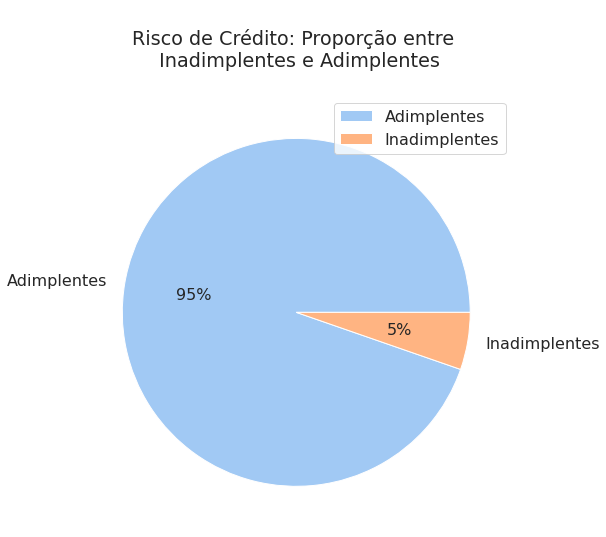

In [ ]:
labels = ['Adimplentes','Inadimplentes']

colors = sns.color_palette('pastel')[0:5]

plt.figure(figsize=(8,8))

plt.pie([df['TARGET'].value_counts()[0], 
         df['TARGET'].value_counts()[1]], 
        labels=labels, 
        colors=colors, 
        autopct='%.0f%%');

plt.title('\nRisco de Crédito: Proporção entre \n Inadimplentes e Adimplentes\n')
plt.legend();

# Digest

In this section you should write down all the main findings of this exploratory data analysis. Furthermore, you should provide a reflection about your own work and effort during the module, highlighting what you believe you have done well and what you should have done differently. This digest should have at least 2500 characters (no spaces).

<p align="justify"> Nas seções de análises uni e multivariadas, observamos as variáveis de acordo com sua natureza: para variáveis numéricas contínuas, olhamos para sua distribuição, histograma, assimetria, curtose, bem como medidas centrais e de dispersão da estatística descritiva, tais como média, moda, mediana, desvio-padrão, entre outros. No caso das variáveis numéricas discretas, observamos a contagem de cada respectivo valor ao longo dos dados de treino, bem como as medidas estatísticas supracitadas. Os dados, por sua vez, possuem 66 colunas (com exceção do atributo chave), e dentre essas existem inúmeras colunas com alta porcentagem de valores faltantes, como a própria coluna de inadimplência (atributo alvo). Nesse caso, de maneira a tornar nossa análise mais robusta e fidedigna, eliminamos essas linhas com valores faltantes e reduzimos a base de maneira significativa. Também, devido ao ruído presente, transformamos os dados de maneira a assegurar o bom senso: por exemplo, colunas de quantidades passarão mais a possuir valores de ponto flutuante, bem como valores negativos. Também, mantemos a versão transformada e sem a remoção de faltantes da base, de maneira a assegurar possíveis comparações e confirmações de comportamentos específicos nos dados. De imediato em nossa análise exploratória, podemos perceber que as variáveis numéricas contínuas possuem um comportamento de distribuição majoritariamente assimetrico, principalmente aquelas que se referem à atributos de renda. No caso das colunas de idades e afins, essa distribuição dos dados tende a ser mais próxima de uma gaussiana, dados fatores randômicos intrínsecos. De maneira a começar a EDA, selecionamos 21 atributos dentre os disponíveis, e dentre esses, selecionamos 7 variáveis para discutir de maneira mais aprofundada e específica. Dentre elas, temos a <code>MEDIARENDACASA</code>, com distribuição altamente assimétrica (positiva), com uma discrepância elevada entre os valores mínimos e máximos presentes nos dados. Temos a variável <code>TEMPOCPF</code> com comportamento oposto em relação à primeira, uma distribuição com assimetria negativa. Em ambos casos, a distribuição é leptocúrtica, e no segundo observamos os dados bém próximos após o quartil $Q_1$. Contudo, temos valores mínimos muito baixos, "puxando" a cauda da distribuição para o lado esquerdo do eixo $x$. No tocante à primeira versão enviada, o <i>checkpoint</i>, concluímos que melhoramos muito, tanto corrigindo os erros da primeira, deixando as análises mais completas e robustas, quanto mais simples e intuitivas. No primeiro caso, trabalhamos com os dados sem a transoformação, fato esse que compromente totalmente a análise, uma vez que estávamos analisando dados que, na prática, não faziam sentido. Para essa próxima etapa, corrigimos esse erro. Também fizemos as análises univariadas de maneira mais eficiente, utilizando laços de repetição, funções e afins para agilizar o processo inicial de EDA, nos garantindo mais tempo para olhar individualmente para as 7 variáveis escolhidas. No tocante à análise multivariada, buscamos realizar mais gráficos de dispersão, exibindo as cores para o atributo <code>TARGET</code>, de maneira a buscar alguma relação e/ou padrão nos dados. Nossas hipóteses foram mais intuitivas, e dentre essas, conseguimos trazer algumas não óbvias, pois consideramos a hipótese não trivial e passível de mais de uma interpretação potencialmente contraditória. Também, eliminamos colunas que dizem respeito à privacidade, fato esse que não fizemos na primeira entrega, e desrespeita a lei supracitada no início deste <i>notebook</i>. Por fim, na análise multivariada buscamos realizar plotagens visualmente completas, com diversidade de cores, e nos preocupamos com esse lado, apesar de não ser completamente necessário nessa etapa (pois ainda não estamos na etapa de <i>storytelling</i>. Também é o caso que, nas plotagens de regressão linear (a maioria delas), realizamos a linha da regressão em três variações distintas dos dados, de maneira a assegurar uma maior confiabilidade e robustez na aceitação ou negação das hipóteses estabelecidas.</p>

# Machine Learning

In this section, you should test different machine learning approaches to **build** and **evaluate** your model.

**IMPORTANT: DO NOT FORGET TO REPORT YOUR PREDICTIONS FOR THE TEST DATA. YOU SHOULD BUILD AND EXPORT A FILE ACCORDING TO THE PROJECT DESCRIPTION WITH THE DEFAULTING PROBABILITIES!**

In [ ]:
def computeKS(y_true, y_prob_positive):
    """
    Description:
        Kolmogorov-Smirnov value obtained from ground-truth targets (y_true) and
        their probabilities (y_prob_positive).
    Params:
        y_true (pd.Series): Ground-truth labels
        y_prob_positive (pd.Series): The probabilities of TARGET=1
    Output:
        ks (float): The KS rate
    """
    vals = list(zip(y_true, y_prob_positive))
    positives = []
    negatives = []
    for a, b in vals:
        if a == 0:
            negatives.append(b)
        else:
            positives.append(b)
    ks = 100.0 * ks_2samp(positives, negatives)[0]
    return ks

## Carregando os Dados para Machine Learning

Carregando uma base já pré-processada para utilização em *Machine Learning*.

In [ ]:
files_ml = ['train_final.csv', 'test_final.csv']

dfm = pd.read_csv(os.path.join(path, files_ml[0]), 
                  na_values=[-9999])

dfm_test = pd.read_csv(os.path.join(path, files_ml[1]), 
                       na_values=[-9999])

In [ ]:
dfm.head()

TEMPOCPF  DISTCENTROCIDADE  ...  TARGET  NULL_VALUES
0  20.338005          0.000000  ...     0.0          1.0
1  26.790774       2209.766591  ...     0.0          1.0
2   9.596740          0.000000  ...     0.0          1.0
3  26.277938       3161.810493  ...     0.0          1.0
4   4.565429          0.000000  ...     1.0          1.0

[5 rows x 46 columns]

## Feature Selection

### VIF

In [ ]:
vif = pd.DataFrame()
vif['Features'] = df.columns
vif['VIF'] = [variance_inflation_factor(df.values, i) \
              for i in range(df.shape[1])]

In [ ]:
pd.options.display.max_rows = 67
vif

Features          VIF
0                       TEMPOCPF    50.835852
1               DISTCENTROCIDADE     2.058105
2                  DISTZONARISCO     2.565781
3                    QTDENDERECO     2.416040
4                       QTDEMAIL     1.657499
5                     QTDCELULAR     1.919003
6                  CELULARPROCON     1.127846
7                    QTDFONEFIXO     3.015079
8                  TELFIXOPROCON     1.196990
9                  INDICEEMPREGO     4.982887
10               PORTEEMPREGADOR     2.808247
11                  SOCIOEMPRESA     1.400110
12            FUNCIONARIOPUBLICO     8.799991
13                   SEGMENTACAO     4.097315
14           SEGMENTACAOCOBRANCA     2.595697
15               SEGMENTACAOECOM     2.776977
16                SEGMENTACAOFIN     2.871614
17            SEGMENTACAOTELECOM     2.757060
18                QTDPESSOASCASA    10.919503
19                MENORRENDACASA     7.957754
20                MAIORRENDACASA    51.809396
21                 SOMARENDACASA    29.445297
22                MEDIARENDACASA    71.962442
23                MAIORIDADECASA   165.081130
24                MENORIDADECASA    55.179725
25                MEDIAIDADECASA   324.123994
26             INDICMENORDEIDADE     1.148320
27             COBRANCABAIXOCASA     1.183936
28             COBRANCAMEDIOCASA     1.030397
29              COBRANCAALTACASA     1.028214
30       SEGMENTACAOFINBAIXACASA     1.219838
31       SEGMENTACAOFINMEDIACASA     1.027284
32           SEGMENTACAOALTACASA          NaN
33              BOLSAFAMILIACASA     1.146178
34        FUNCIONARIOPUBLICOCASA     8.209521
35                 IDADEMEDIACEP   139.030316
36                PERCENTMASCCEP   325.724340
37                 PERCENTFEMCEP   312.207733
38          PERCENTANALFABETOCEP     2.418506
39            PERCENTPRIMARIOCEP     3.432605
40         PERCENTFUNDAMENTALCEP     6.727901
41               PERCENTMEDIOCEP     9.286721
42            PERCENTSUPERIORCEP     5.487105
43            PERCENTMESTRADOCEP     2.376253
44           PERCENTDOUTORADOCEP     2.571706
45        PERCENTBOLSAFAMILIACEP     4.689506
46  PERCENTFUNCIONARIOPUBLICOCEP     2.265803
47                 MEDIARENDACEP    21.588732
48                  PIBMUNICIPIO    10.671260
49        QTDUTILITARIOMUNICIPIO     8.912704
50         QTDAUTOMOVELMUNICIPIO    44.633503
51          QTDCAMINHAOMUNICIPIO    20.166427
52       QTDCAMINHONETEMUNICIPIO    74.330110
53              QTDMOTOMUNICIPIO    12.247410
54          PERCENTPOPZONAURBANA   120.322541
55                  IDHMUNICIPIO  1421.822329
56               ESTIMATIVARENDA    10.059478
57           QTDDECLARACAOISENTA     1.648061
58               QTDDECLARACAO10    30.051109
59           QTDDECLARACAOREST10     8.135269
60          QTDDECLARACAOPAGAR10     4.686606
61   RESTITUICAOAGENCIAALTARENDA     1.115326
62                  BOLSAFAMILIA     1.028665
63         ANOSULTIMARESTITUICAO     3.618818
64          ANOSULTIMADECLARACAO     2.027603
65     ANOSULTIMADECLARACAOPAGAR     3.076841
66                        TARGET     1.071680

### `SelectKBest`

In [ ]:
X_skb = dfm.drop(['TARGET'], axis=1)
y_skb = dfm['TARGET']
y_skb = dfm['TARGET'].astype('int32')

skb = SelectKBest(k='all')
skb.fit(X_skb, y_skb)

relevance_skb = pd.Series(data=skb.scores_, 
                          index=X_skb.columns.values)

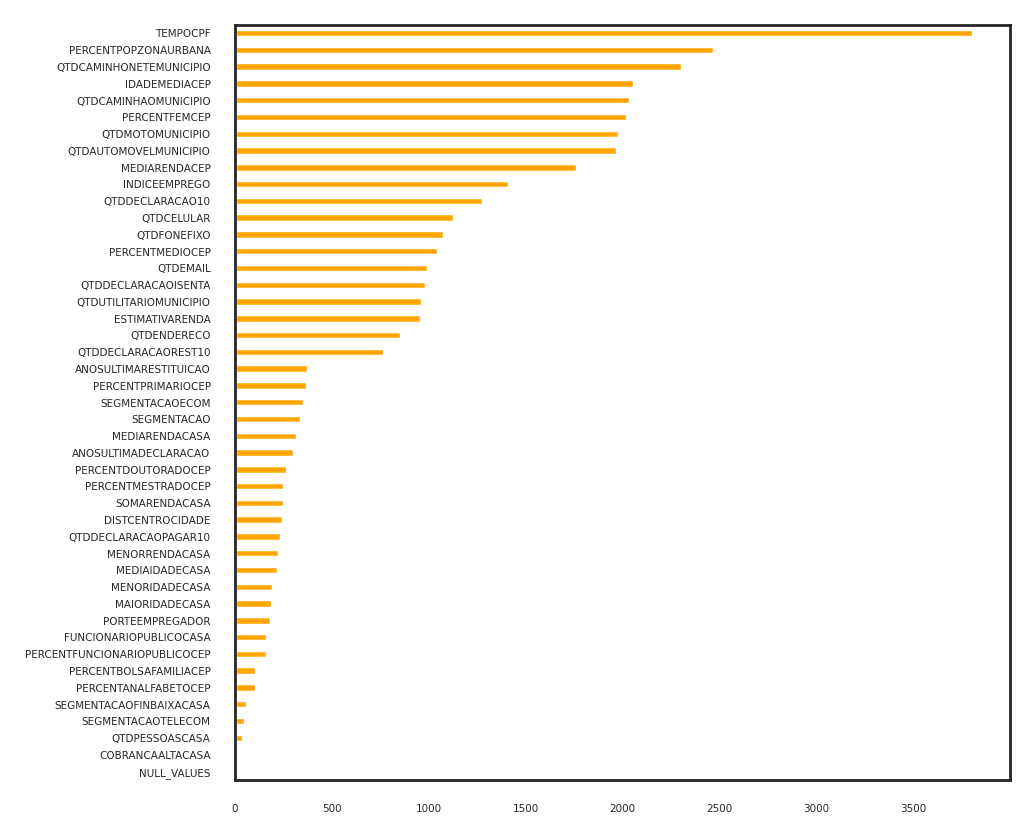

In [ ]:
plt.rc('font', size=3);
fig, ax = plt.subplots(nrows=1, 
                       figsize=(4,4),
                       dpi=250)

relevance_skb.sort_values().plot(kind='barh',
                                 color='orange');

### Feature Importance Pipeline: `XGBClassifier`

['SEGMENTACAOFINMEDIACASA', 'FUNCIONARIOPUBLICOCASA', 'SEGMENTACAOALTACASA']
64
25.87555436726555
--------------------------------------------------------------------------------
['CELULARPROCON', 'RESTITUICAOAGENCIAALTARENDA', 'COBRANCAMEDIOCASA']
61
26.175073209468646
--------------------------------------------------------------------------------
['QTDDECLARACAOREST10', 'QTDDECLARACAOPAGAR10', 'COBRANCABAIXOCASA']
58
26.09454607630103
--------------------------------------------------------------------------------
['FUNCIONARIOPUBLICO', 'TELFIXOPROCON', 'COBRANCAALTACASA']
55
25.943980304251284
--------------------------------------------------------------------------------
['PERCENTDOUTORADOCEP', 'SEGMENTACAOFIN', 'INDICMENORDEIDADE']
52
25.873231016691413
--------------------------------------------------------------------------------
['PERCENTMASCCEP', 'PERCENTFUNCIONARIOPUBLICOCEP', 'BOLSAFAMILIA']
49
25.97982357278532
------------------------------------------------------------

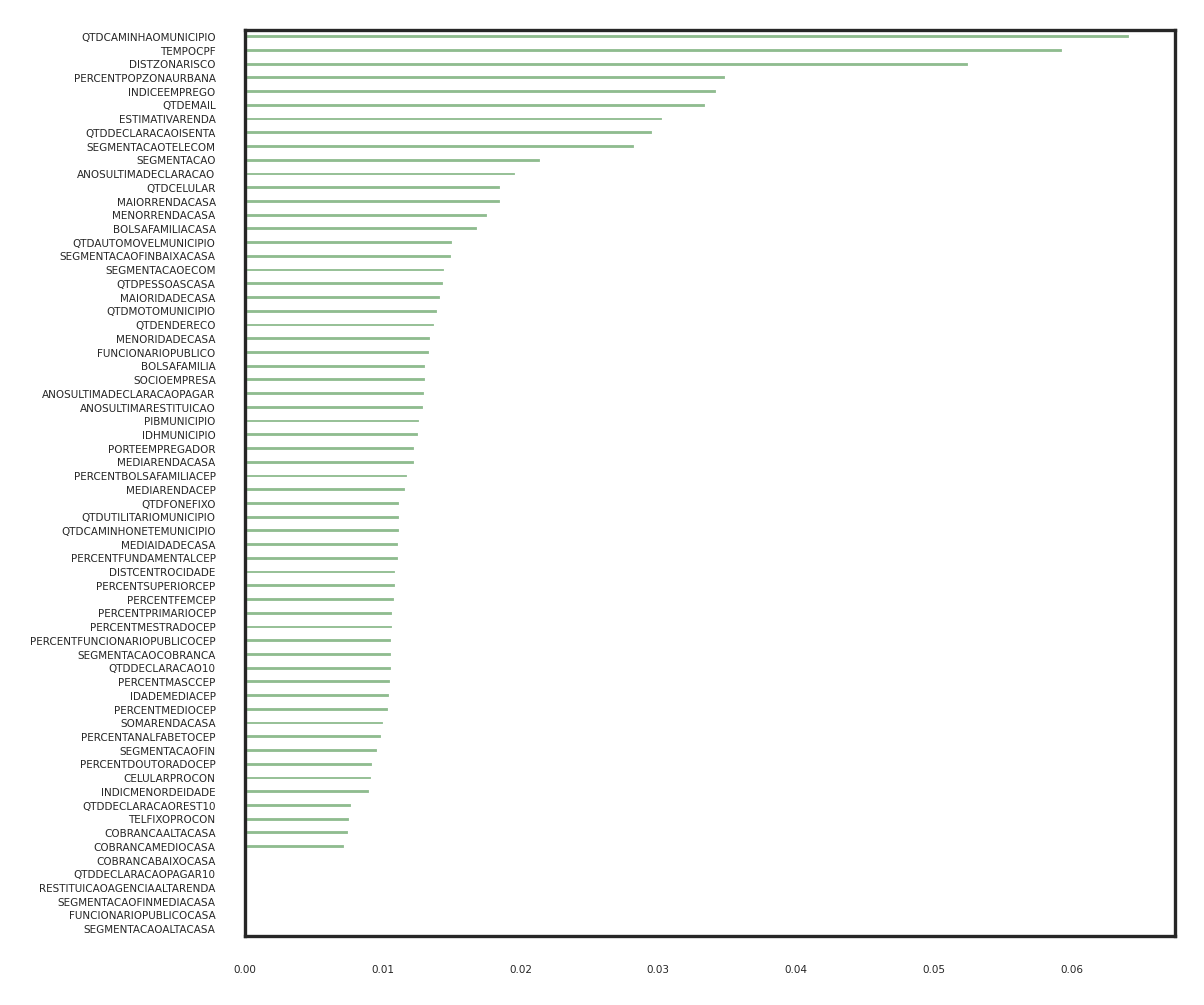

In [ ]:
df_temp = df_train_full.copy()
ks_values = []

# range(21)
for i in range(7):

    X_t = df_temp.drop(['TARGET'], axis=1).values
    y_t = df_temp['TARGET'].astype('int32').values

    X_train_t, X_test_t, \
    y_train_t, y_test_t = train_test_split(X_t, np.reshape(y_t,(-1,1)), 
                                           test_size=0.25, 
                                           random_state=42)
    
    params_xgb = {'n_estimators': 600, 
                  'learning_rate': 0.05, 
                  'max_depth': 3,
                  'subsample': 0.8,
                  'colsample_bytree': 0.9,
                  'gamma': 1}

    clf = XGBClassifier(**params_xgb)
    clf.fit(X_train_t, y_train_t)
    clf_probs = clf.predict_proba(X_test_t)
    clf_probs_true = [prob[1] for prob in clf_probs]
    ks = computeKS(y_test_t, clf_probs_true)
    
    ks_values.append(ks)

    feature_relevance = pd.Series(data=clf.feature_importances_,
                                  index=df_temp.columns.values[:-1])
    
    if i == 0:
        plt.rc('font', size=2.5)
        fig, ax = plt.subplots(nrows=1, 
                               figsize=(4,4),
                               dpi=300)

        feature_relevance.sort_values().plot(kind='barh', 
                                             color='darkseagreen');
    
    drop_set = list(feature_relevance \
                    .sort_values(ascending=False)[-3:] \
                    .keys() \
                    .values)
    
    df_temp.drop(drop_set, axis=1, inplace=True)
    
    print(drop_set)
    print(len(df_temp.columns))
    print(ks)
    print('-' * 80)

### Selecionando as Features

<p align="justify">Temos dois sets de colunas a serem removidas, respectivamente <code>drop_set_1</code> e <code>drop_set_2</code>. A primeira se refere às features selecionadas com base na importância relativa ao modelo treinado (<code>XGBClassifier</code>), selecionando um valor $k$ das melhores features (que resultaram nos valores de KS mais elevados). Contudo, tais features também foram combinadas experimentalmente com features relevantes, obtidas através do <code>SelectKBest</code>, originando melhores resultados. O segundo set é relacionado às features originárias do modelo treinado combinadas com outras features de maneira experimental, buscando melhores resultados (ainda que através da eliminação de features específicas).</p>

In [ ]:
drop_set_1 = ['SEGMENTACAOFINMEDIACASA', 'FUNCIONARIOPUBLICOCASA', 'SEGMENTACAOALTACASA',
              'COBRANCAMEDIOCASA', 'COBRANCAALTACASA', 'RESTITUICAOAGENCIAALTARENDA',
              'TELFIXOPROCON', 'CELULARPROCON', 'QTDDECLARACAOPAGAR10',
              'PERCENTDOUTORADOCEP', 'ANOSULTIMARESTITUICAO', 'QTDDECLARACAOREST10',
              'QTDUTILITARIOMUNICIPIO', 'PERCENTFUNCIONARIOPUBLICOCEP', 'COBRANCABAIXOCASA',
              'IDADEMEDIACEP', 'PERCENTANALFABETOCEP', 'PERCENTFEMCEP',
              'ANOSULTIMADECLARACAOPAGAR', 'PERCENTMESTRADOCEP', 'PERCENTSUPERIORCEP',
              'DISTCENTROCIDADE', 'INDICMENORDEIDADE', 'QTDCAMINHONETEMUNICIPIO', 
              'PERCENTFUNDAMENTALCEP', 'MEDIARENDACASA', 'PERCENTBOLSAFAMILIACEP', 
              'PORTEEMPREGADOR', 'MAIORIDADECASA', 'MENORIDADECASA', 
              'ANOSULTIMADECLARACAO', 'QTDPESSOASCASA', 'BOLSAFAMILIA',
              'MENORRENDACASA', 'SEGMENTACAOECOM', 'MAIORRENDACASA', 
              'QTDDECLARACAO10', 'SOCIOEMPRESA']

drop_set_2 = ['ANOSULTIMADECLARACAOPAGAR','BOLSAFAMILIA','BOLSAFAMILIACASA',
              'CELULARPROCON','COBRANCABAIXOCASA','COBRANCAMEDIOCASA',
              'DISTZONARISCO','FUNCIONARIOPUBLICO','IDHMUNICIPIO',
              'INDICMENORDEIDADE','MAIORRENDACASA','PERCENTFUNDAMENTALCEP',
              'PERCENTSUPERIORCEP','PIBMUNICIPIO','RESTITUICAOAGENCIAALTARENDA',
              'SEGMENTACAOALTACASA','SEGMENTACAOCOBRANCA','SEGMENTACAOFIN',
              'SEGMENTACAOFINMEDIACASA','SOCIOEMPRESA','TELFIXOPROCON']

df.drop(drop_set_1, axis=1, inplace=True)

### Heatmap

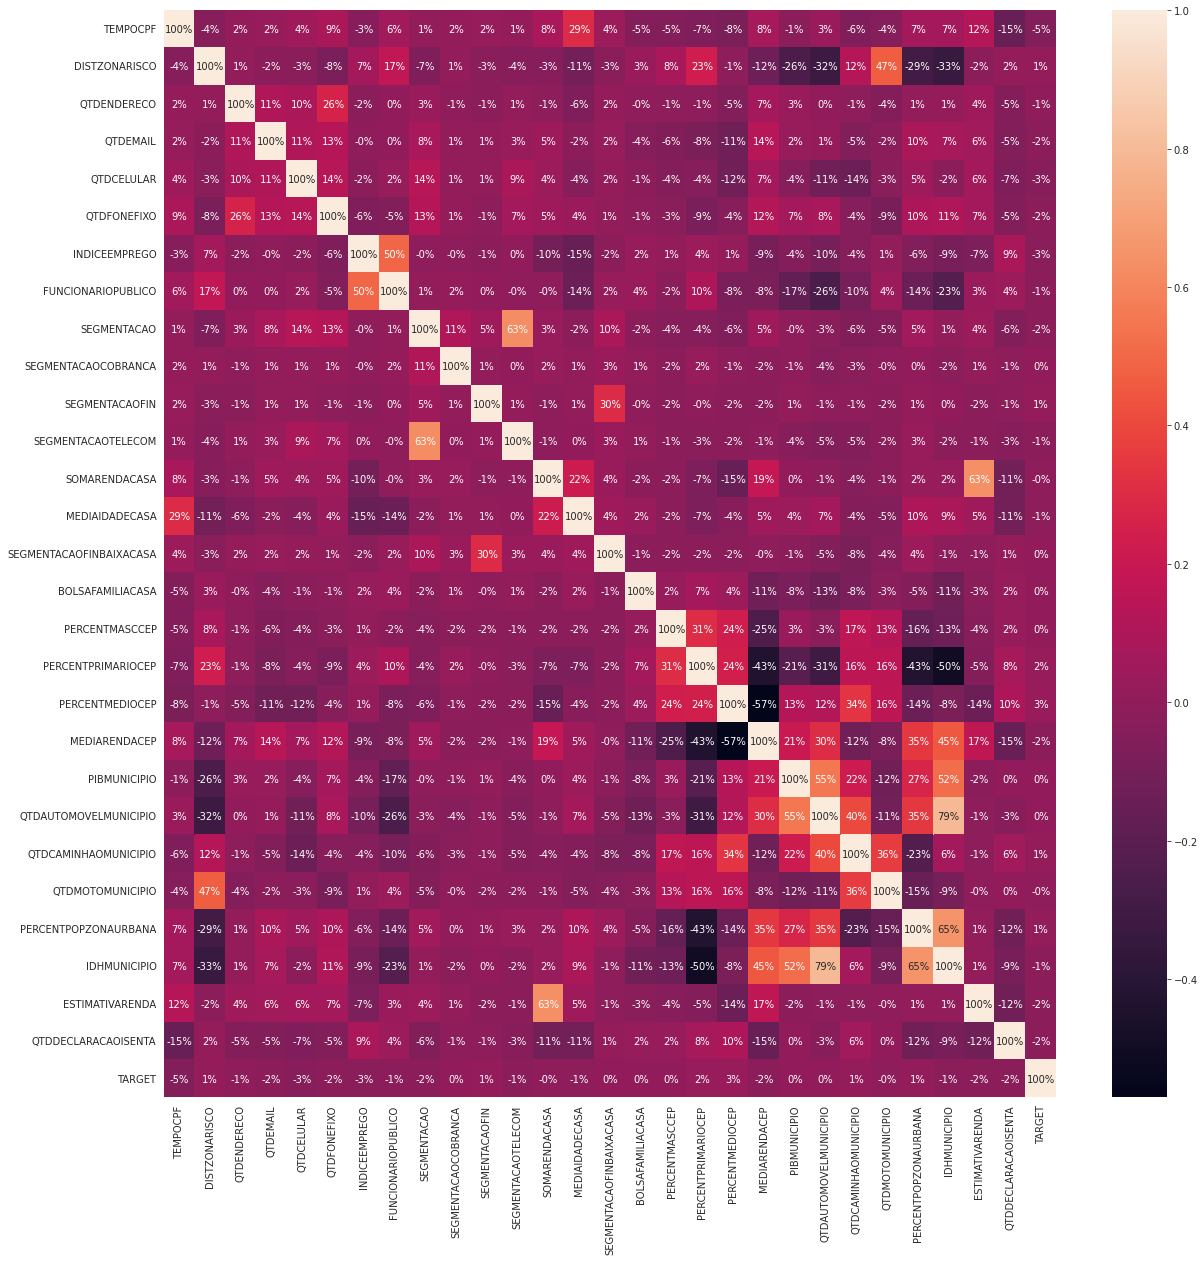

In [ ]:
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.size'] = 10

cor = df.corr()
sns.heatmap(cor, annot=True, fmt='.0%')
plt.show()

## Preparação dos Dados

### Separação em Treino e Teste

In [ ]:
X = dfm.drop(['TARGET'], axis=1).values
y = dfm['TARGET'].astype('int32').values

X_train, X_test, \
y_train, y_test = train_test_split(X, np.reshape(y,(-1,1)), 
                                   test_size=0.25, 
                                   random_state=42)

### Normalização

In [ ]:
def data_normalizer(Normalizer: object, 
                    X: pd.DataFrame) -> pd.DataFrame:
    """
    Realiza a normalização dos dados
    Params:
        Normalizer: classe do modelo de normalização
        X: dados a serem normalizados
    Returns:
        X dados normalizados
    """
    Normalizer.fit(np.array(X))
    X = Normalizer.transform(X)   
    return X

In [ ]:
"""Opções de uso:
       MinMaxScaler(feature_range=(0,1))
       StandardScaler()
       RobustScaler()
       PowerTransformer(method='box-cox')"""

# X_train = data_normalizer(MinMaxScaler(feature_range=(0,1)),
#                           X_train, 
#                           y_train)
# print(X_train.max())
# print(X_train.min())
pass

### Balanceamento

In [ ]:
# from imblearn.over_sampling import RandomOverSampler, \
#                                    SMOTE

# from imblearn.under_sampling import RandomUnderSampler, \
#                                     NearMiss

In [ ]:
def data_balancer(Balancer: object, 
                  X: pd.DataFrame, 
                  y: pd.DataFrame) -> tuple:
    """
    Realiza o balanceamento de classes nos dados
    Params:
        Balancer: classe do modelo de balanceamento
        X: dados dos atributos
        y: target
    Returns:
        X, y: dados balanceados
    """
    X, y = Balancer.fit_resample(X, y)
    return X, y

In [ ]:
"""Opções de uso:
       SMOTE()
       RandomUnderSampler()
       RandomOverSampler()
       NearMiss(version=1)
       NearMiss(version=2)
       NearMiss(version=3)"""

# X_train, y_train = data_balancer(NearMiss(version=1),
#                                  X_train,
#                                  y_train)
# print(X_train)
# print(y_train)
pass

## Pipelines de Machine Learning



<p align="justify">Pipeline criada para testagem rápida de modelos de Machine Learning. Nos experimentos, passamos o modelo desejado no parâmetro da função, e após a execução recebemos o valor do KS para os dados de validação, passados também no parâmetro.</p>

In [ ]:
def ml_pipeline(Model: object, 
                params: dict, 
                train_test: tuple) -> float:
    """
    Pipeline responsável por gerar o modelo desejado, juntamente
    com seus parâmetros, e treiná-lo nos dados fornecidos. Para a 
    validação, é computado o KS.

    Params:
        Model: Modelo de Machine Learning
        params: Dicionário com parâmetros do modelo
        train_test: X_train, X_test, y_train e y_test, todos em tupla

    Returns:
        Retorna o KS dos dados de validação
    """
    clf = Model(**params)
    clf.fit(X_train, y_train)
    clf_probs = clf.predict_proba(X_test)
    clf_probs_true = [prob[1] for prob in clf_probs]
    ks = computeKS(y_test, clf_probs_true)
    return ks

<p align="justify">Foram testados vários modelos, tais como <code>RandomForestClassifier</code>, <code>LighGBM</code>, <code>AdaBoost</code>, entre outros.</p>

In [ ]:
%%time
ml_pipeline(LogisticRegression,
            {'max_iter': 100},
            (X_train, X_test, y_train, y_test))

CPU times: user 6.14 s, sys: 2.23 s, total: 8.37 s
Wall time: 4.46 s


18.471405055335605

In [ ]:
# %%time
# ml_pipeline(RandomForestClassifier,
#             {'n_estimators': 10},
#             (X_train, X_test, y_train, y_test))

## Utilizando `XGBClassifier` nos Dados de Treino

In [ ]:
%%time
xgb = XGBClassifier(n_estimators=600, 
                    learning_rate=0.05, 
                    max_depth=3,
                    subsample=0.8,
                    colsample_bytree=0.9,
                    gamma=1)

xgb.fit(X_train, y_train)

CPU times: user 3min 43s, sys: 234 ms, total: 3min 43s
Wall time: 3min 42s


In [ ]:
# Importância dos atributos para o modelo treinado
relevance = pd.Series(data=xgb.feature_importances_, 
                      index=list(dfm.drop(['TARGET'], axis=1)))

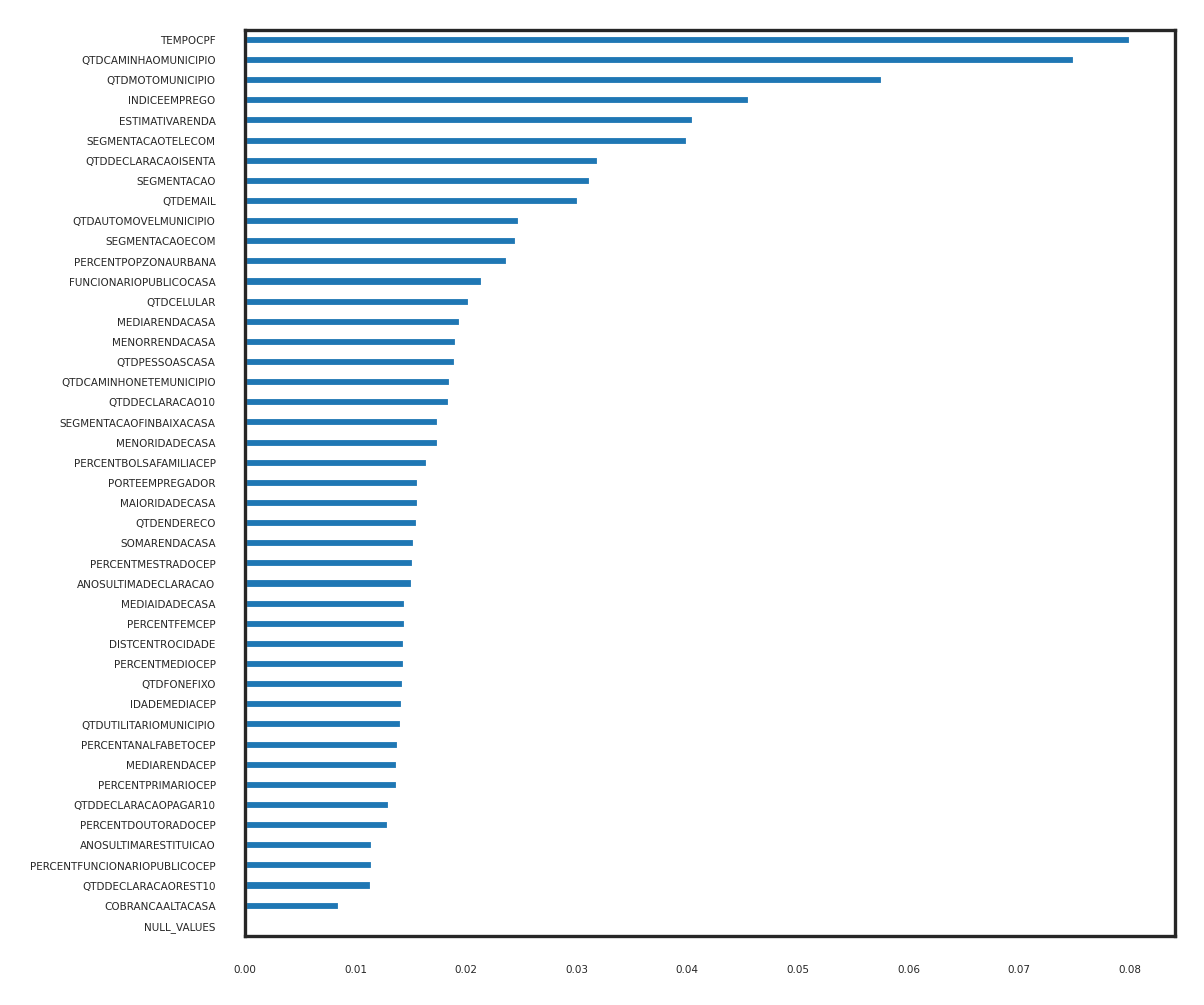

In [ ]:
plt.rc('font', size=2.5)
fig, ax = plt.subplots(nrows=1, 
                       figsize=(4,4),
                       dpi=300)

relevance.sort_values().plot(kind='barh');

In [ ]:
xgb_preds = xgb.predict(X_test)
xgb_probs = xgb.predict_proba(X_test)

print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     48591
           1       0.00      0.00      0.00      5204

    accuracy                           0.90     53795
   macro avg       0.45      0.50      0.47     53795
weighted avg       0.82      0.90      0.86     53795



In [ ]:
xgb_probs_true = [prob[1] for prob in xgb_probs]
computeKS(y_test, xgb_probs_true)

26.34125664294374

## Utilizando `XGBClassifier` nos Dados de Teste

In [ ]:
%%time
xgb_teste = XGBClassifier(n_estimators=600, 
                          learning_rate=0.05, 
                          max_depth=3,
                          subsample=0.8,
                          colsample_bytree=0.9,
                          gamma=1)

xgb_teste.fit(X, y)

CPU times: user 4min 54s, sys: 644 ms, total: 4min 55s
Wall time: 4min 54s


In [ ]:
# Probabilidades de Inadimplência
xgb_teste_probs = xgb_teste.predict_proba(dfm_test.values)
xgb_teste_probs_true = [prob[1] for prob in xgb_teste_probs]

# Gerando o output com as probabilidades em csv
df_output = pd.DataFrame({'TEAM_D20': xgb_teste_probs_true})
df_output.to_csv('TEAM_D20.csv', index=False)

In [ ]:
# DataFrame do arquivo de output
df_output

TEAM_D20
0      0.120826
1      0.083084
2      0.086135
3      0.083332
4      0.071036
...         ...
92064  0.047065
92065  0.070015
92066  0.301838
92067  0.111171
92068  0.212399

[92069 rows x 1 columns]

# Future work

In this cell, please provide at least 3 different ideas that you would like to pursuit within this dataset. That may include, for example, the use of machine learning techniques towards a goal, or analyzing variables that you had no time to during this work. 
Please provide **details** on how you would tackle this problem and provide specifics on which techniques should be used for such purposes.
This section should contain, at least, 2500 characters (no spaces).

<p align="justify"> Na etapa de <i>Machine Learning</i>, chegamos a testar várias das técnicas apresentadas em aula, bem como utilizar algumas destas. Por exemplo, testamos alguns modelos de <i>Machine Learning</i>, como <code>RandomForest</code>, <code>AdaBoost</code>, <code>KNN</code>, Regressão Logística, entre outros. Dentre esses modelos, alguns apresentam melhores resultados após a normalização dos dados, portanto chegamos a testar algumas destas alternativas, estimando sempre o KS para a fração dos dados destinados à validação. Também encontramos o problema do desbalanceamento, portanto utilizamos de algumas técnicas (tais como <code>SMOTE</code>), porém, para o nosso modelo final (<code>XGBoost</code>), essas técnicas não trouxeram ganho significativo. O modelo utilizado, por si só já teve bons resultados, juntamente com o <code>LightGBM</code>, e logo abaixo destes e <code>AdaBoost</code>. Entre o <code>LightGBM</code> e o <code>XGBoost</code>, optamos pelo primeiro devido à constância e solidez dos valores de KS obtidos. Em contrapartida, o modelo <code>LightGBM</code> é muito mais rápido na hora de realizar o treinamento e estimação do KS. Como alternativa, chegamos a construir uma base reduzida, mantendo algumas estatísticas gerais das colunas, bem como suas distribuições, para realizar o teste de algoritmos e, principlamente, a tunagem de hiperparâmetros do <code>XGBoost</code> pela Otimização Bayesiana. Considerando o primeiro fato mencionado, o modelo e seus parâmetros, também foi de crucial importância para aumentarmos o KS a seleção de atributos. Inicialmente, utilizamos o <code>SelectKBest</code> para selecionar algumas features e conduzir alguns experimentos. Após notarmos algumas quedas nos valores de KS, observamos que a combinação de atributos, muitas vezes de variáveis não tão expressivas individualmente através do <code>SelectKBest</code>, ocasionavam em melhores resultados de KS. Conduzimos, portanto, uma seleção gradativa das melhores variáveis após o treinamento do <code>XGBoost</code>, selecionando algumas dessas variáveis e combinando-as com outras obtidas pelo <code>SelectKBest</code>. Ao final, fizemos uma junção dos gráficos de importância de variáveis, matrizes de correlação e análises uni e multivariadas para selecionar dois conjuntos de variáveis a serem dropadas, de maneira a otimizar nosso modelo. Através dos passos descritos acima, conseguimos um KS na caso do 26 à 27. Porém, tivemos algumas ideias ao longo do processo para otimizar esses reusultados. Dentre elas, a primeira: criação de novas features. Nós chegamos a criar features para o modelo, criando razões entre atributos importantes, somas, médias, razões de razões, funções de logaritmos, e foi uma etapa bem trabalhosa. Após algumas tentativas, conseguimos um valor para o KS em validação de <code>26.96</code>, porém esses resultados não se demonstraram sólidos e constantes para uma testagem. Isso nos deixou céticos em relação a criar novas features, apesar de ser muito promissor, também é arriscado. Concluímos que existem muitas possibilidades para <i>Feature Engineering</i>, e gostaríamos de explorar essas ideias futuramente para aprimorar nosso KS, visto que observando a base, é possível sumarizar as colunas e entender certas nuances que separam os adimplentes dos inadimplentes, e através dessas nuances, poderíamos gerar novas features que exemplificassem isso para o nosso modelo. A segunda ideia de trabalho futuro é utilizar uma rede neural para as classificações, gerando as probabilidades. Pensamos na possibilidade de criar novas features, e dada e extenção e relação de padrões nos dados, nuances entre os atributos, uma rede neural seria apta a "detectar" esses padrões, e para isso iríamos pré processar os dados, realizando as normalizações adequadas. Junto dessa rede neural, iríamos treinar o modelo <code>XGBoost</code> atual, junto das novas features, e combinaríamos esses classificadores com o <code>StackingClassifier</code>, de maneira a construir um modelo mais robusto. Chegamos a utilizar o <code>StackingClassifier</code>, porém ser resultados expressivos entre o <code>XGBoost</code> e demais modelos que não resultavam em valores de KS mais altos. Também combinamos o <code>XGBoost</code> com o <code>LightGBM</code>, porém o KS se manteve praticamente idêntico ao obtido com os classificadores individualmente, e isso provavelmente se deve à semelhança dos modelos. Ainda sobre o <code>StackingClassifier</code>, tentamos realizar diversas combinações de modelos diferentes, dentre esses tanto modelos tradicionais quanto ensembles. Chegamos a criar um <code>BaggingClassifier</code> de <code>XGBoost</code> e <code>LighGBM</code>, e então combiná-los em um <code>StackingClassifier</code>, mas os resultados finais não foram expressivos se comparados aos dos modelos individualmente. Repetimos a mesma ideia com o <code>VotingClassifier</code>, mas também sem aumentos expressivos. Concluímos, portanto, que seria um experimento válido combinar uma rede neural com o <code>XGBoost</code> no <code>StackingClassifier</code>, uma vez que são modelos distintos que "captariam" padrões diferentes nos dados, e isso poderia ocasionar em um KS maior, principalmente se combinado às novas features mencionadas. Por último, pensamos na possibilidade de fragmentar a base de dados e gerar um classificador otimizado especialmente para cada característica da base, e então combinando esses algoritmos para gerar um melhor valor de KS, buscando contemplar todas essas diferentes nuances. Por último, e como um passo extra, poderíamos juntar todas as ideias supracitadas, criando diferentes modelos em diferentes regiões da base, separados por carcterísticas distintas do comportamento dos dados, separando cada um como <code>XGBoost</code>, <code>LighGBM</code>, rede neural ou então uma combinação destes com um <code>StackingClassifier</code>; junto disso, seria viável empregar o esforço computacional neessário para otimizar os hiperparâmetros de cada um desses modelos. Ao fim, poderíamos combiná-los de diferentes formas, utilizando meta classificadores, agrupando estes, ou então através de um algorítmo heurístico ou genético.</p>


# Final Steps


1. Save this report as a jupyter notebook (`.ipynb`)
2. Save a copy of this report as a PDF file (`.pdf`)
3. Copy the dataset
4. Zip it all together within a single file (`<your_name>.zip`)
5. Send it over using Blackboard.